In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical

def mnist_loader(standard=False, onehot=False):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = np.expand_dims(x_train, 3)

    x_train = x_train / 255.  # 0~1
    x_test = x_test / 255.  # 0~1
    if standard:
        x_train = (x_train * 2) - 1
        x_test = (x_test * 2) - 1
    if onehot:
        y_train = to_categorical(y_train, num_classes=10)
        y_test = to_categorical(y_test, num_classes=10)
    return x_train, y_train, x_test, y_test


def fmnist_loader(standard=False, onehot=False):
    (x_train, y_train), (x_test,
                         y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = np.expand_dims(x_train, 3)

    x_train = x_train / 255.
    x_test = x_test / 255.
    if standard:
        x_train = (x_train * 2) - 1
        x_test = (x_test * 2) - 1
    if onehot:
        y_train = to_categorical(y_train, num_classes=10)
        y_test = to_categorical(y_test, num_classes=10)
    return x_train, y_train, x_test, y_test




In [7]:


class GAN():

    def __init__(self, gene, disc, img_shape, noise_dims, label_dims=None):
        self.name = 'GAN'
        self.gene = gene
        self.disc = disc
        self.img_shape = img_shape
        self.noise_dims = noise_dims
        self.label_dims=label_dims
        

    def Compile(self, loss='binary_crossentropy', optimizer='adam'):

        self.disc.compile(loss=loss, optimizer=optimizer)
        self.disc.trainable = False

        input_noise = layers.Input(shape=self.noise_dims)
        if self.label_dims:
            input_label = layers.Input(shape=self.label_dims)
            fake_img = self.gene([input_noise, input_label])
            logit = self.disc([fake_img, input_label])
            self.gan = models.Model([input_noise, input_label], logit, name=self.name)
            self.gan.compile(loss=loss, optimizer=optimizer)
        else:
            fake_img = self.gene(input_noise)
            logit = self.disc(fake_img)
            self.gan = models.Model(input_noise, logit, name=self.name)
            self.gan.compile(loss=loss, optimizer=optimizer)

    def _make_datasets(self, x_data, y_data=None):
        if self.label_dims:
            dataset = tf.data.Dataset.from_tensor_slices((x_data,y_data)).shuffle(1)
        else:
            dataset = tf.data.Dataset.from_tensor_slices(x_data).shuffle(1)
        dataset = dataset.batch(self.batch_size,drop_remainder=True).prefetch(1)
        return dataset

    def _make_constants(self):
        zeros = tf.constant([0.], shape=[self.batch_size, 1])
        ones = tf.constant([1.], shape=[self.batch_size, 1])
        return zeros, ones

    def _make_random(self):
        return tf.random.normal(shape=[self.batch_size, self.noise_dims])
    def _make_random_label(self):
        rnd_labels = np.random.randint(0, self.label_dims, self.batch_size)
        rnd_labels = utils.to_categorical(rnd_labels, self.label_dims)
        return rnd_labels

    def fit(self, x_data, y_data=None, epochs=1, batch_size=32, standard=False):

        # setting
        self.batch_size = batch_size
        if self.label_dims:
            train_ds = self._make_datasets(x_data, y_data)
            seed_noises = tf.random.normal(shape=[30, self.noise_dims])
            seed_labels =  np.tile(utils.to_categorical(np.arange(10), 10), (3,1))
        else:
            train_ds = self._make_datasets(x_data)
        zeros, ones = self._make_constants()

        # train
        history = {'d_loss': [], 'g_loss': []}
        for epoch in range(1 + epochs):
            if epoch > 0:
                for h in history:
                    history[h].append(0)
                
                if self.label_dims:
                    for real_imgs , real_labels in train_ds:
                        # phase 1 - training the discriminator
                        fake_imgs = self.gene.predict_on_batch( [self._make_random(), real_labels ])

                        self.disc.trainable = True
                        d_loss_real = self.disc.train_on_batch([real_imgs, real_labels], ones)
                        d_loss_fake = self.disc.train_on_batch([fake_imgs, real_labels], zeros)
                        d_loss = (0.5 * d_loss_real) + (0.5 * d_loss_fake)

                        # phase 2 - training the generator
                        self.disc.trainable = False
                        g_loss = self.gan.train_on_batch([self._make_random(), self._make_random_label()], ones)

                        history['d_loss'][-1] += d_loss
                        history['g_loss'][-1] += g_loss

                    # end 1 epoch
                    print('* epoch: %i, d_loss: %f, g_loss: %f' %
                          (epoch, history['d_loss'][-1], history['g_loss'][-1]))
                    fake_imgs = self.gene.predict([seed_noises, seed_labels])
                    display_sample_img(fake_imgs, (3, 10), epoch=epoch,standard=standard, size=2)
                else:
                    for real_imgs in train_ds:
                        # phase 1 - training the discriminator
                        fake_imgs = self.gene.predict_on_batch(self._make_random())

                        self.disc.trainable = True
                        d_loss_real = self.disc.train_on_batch(real_imgs, ones)
                        d_loss_fake = self.disc.train_on_batch(fake_imgs, zeros)
                        d_loss = (0.5 * d_loss_real) + (0.5 * d_loss_fake)

                        # phase 2 - training the generator
                        self.disc.trainable = False
                        g_loss = self.gan.train_on_batch(self._make_random(), ones)

                        history['d_loss'][-1] += d_loss
                        history['g_loss'][-1] += g_loss

                    # end 1 epoch
                    print('* epoch: %i, d_loss: %f, g_loss: %f' %
                          (epoch, history['d_loss'][-1], history['g_loss'][-1]))
                    fake_imgs = self.gene.predict(self._make_random())
                    display_sample_img(fake_imgs, (2, 8), standard=standard, size=2)

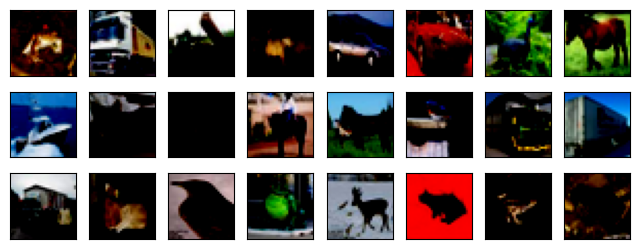

((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

In [9]:
IMG_SHAPE = (32,32,3)
NOISE_DIM = 128
LABEL_DIM = 10

x_train, y_train, x_test, y_test = cifar10_loader(True,True)
display_sample_img(x_train, (3,8), True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# x_train, _, _, _ = mnist_loader(True, True)
# display_sample_img(x_train, (3,8), True)
# x_train.shape

In [10]:
builder = BuildModel(IMG_SHAPE, NOISE_DIM, label_dim=10)
gene = builder.build_gene(last_activation='tanh') # tanh : -1 ~ 1 아웃풋  sigmoid: 0~1 아웃풋
disc = builder.build_disc()
gene.summary()
disc.summary()

Model: "C_Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 condition (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 138)          0           ['noise[0][0]',                  
                                                                  'condition[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 8192)         1138688     ['concatenate[0][0]']  

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 C_Generator (Functional)       (None, 32, 32, 3)    1349123     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 C_Discriminator (Functional)   (None, 1)            250113      ['C_Generator[0][0]',          

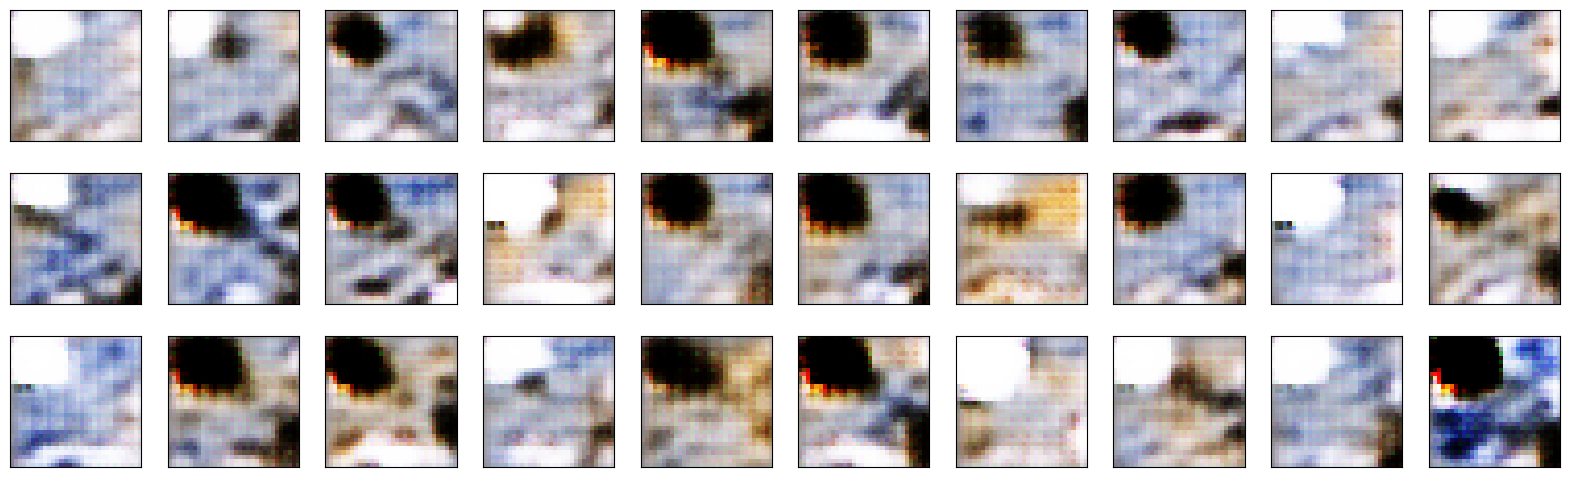

* epoch: 2, d_loss: 387.556989, g_loss: 5222.770494
1/1 [==============================] - 0s 12ms/step


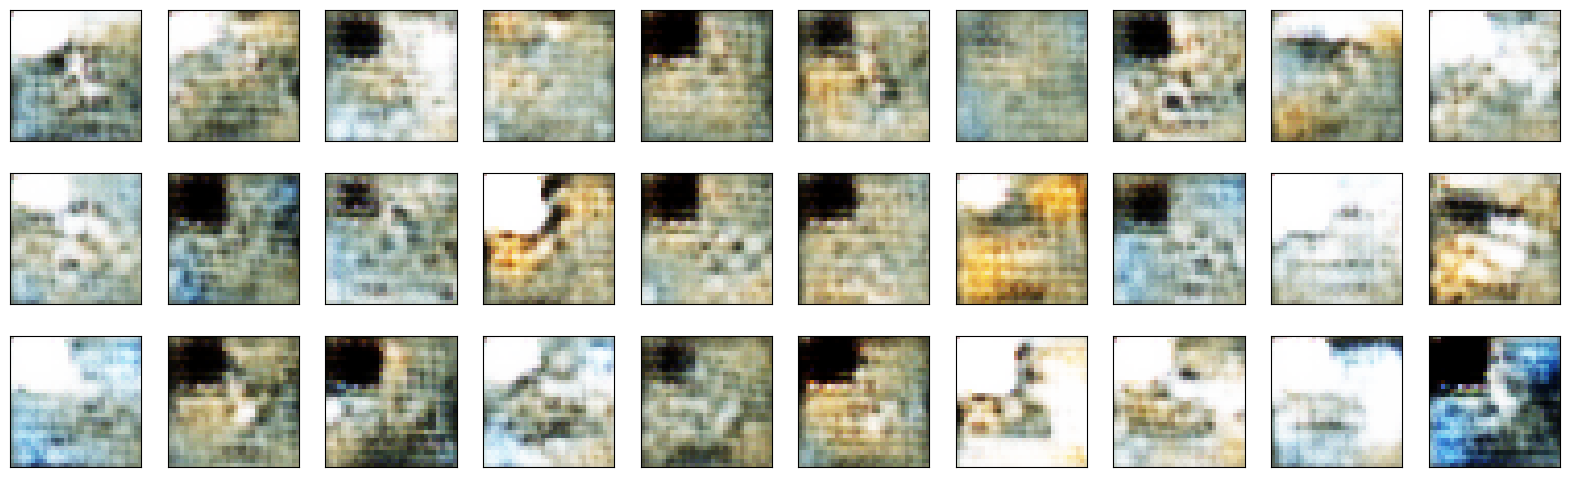

* epoch: 3, d_loss: 347.029510, g_loss: 5904.521154
1/1 [==============================] - 0s 12ms/step


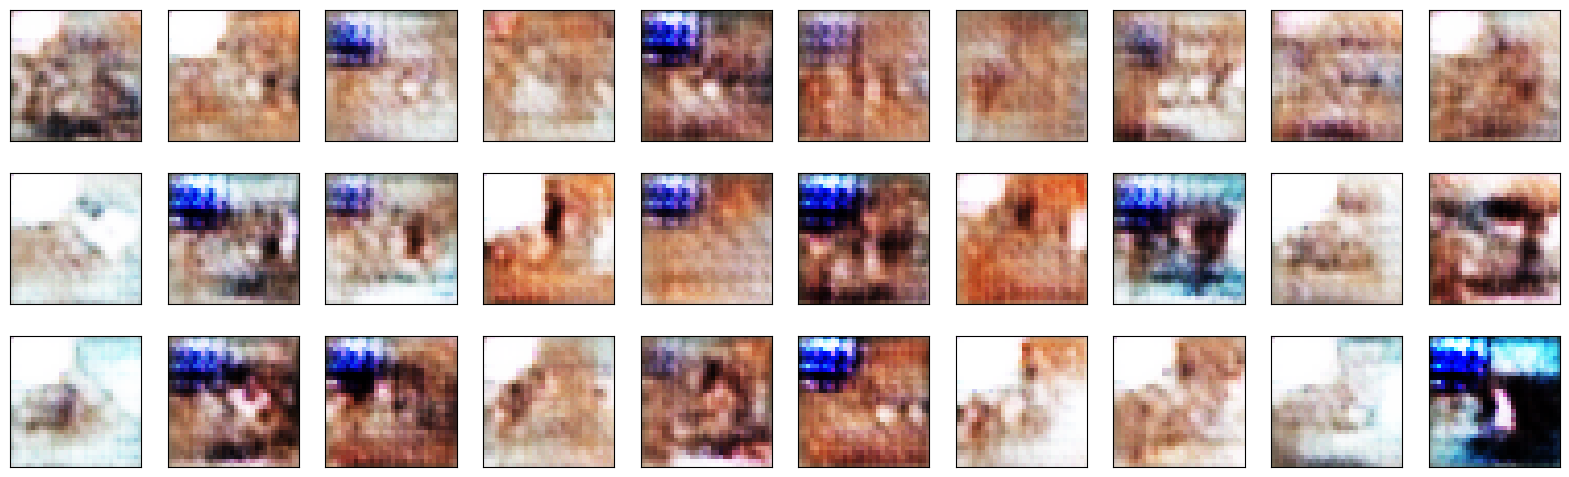

* epoch: 4, d_loss: 337.024226, g_loss: 5590.005737
1/1 [==============================] - 0s 13ms/step


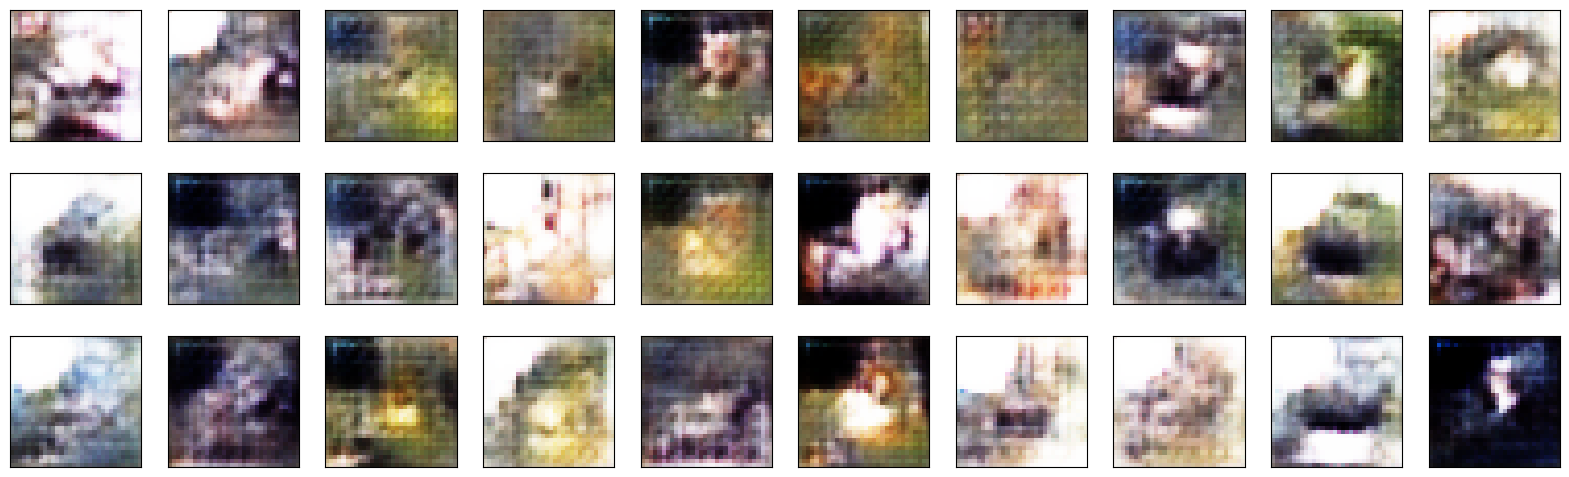

* epoch: 5, d_loss: 334.019665, g_loss: 5403.951229
1/1 [==============================] - 0s 14ms/step


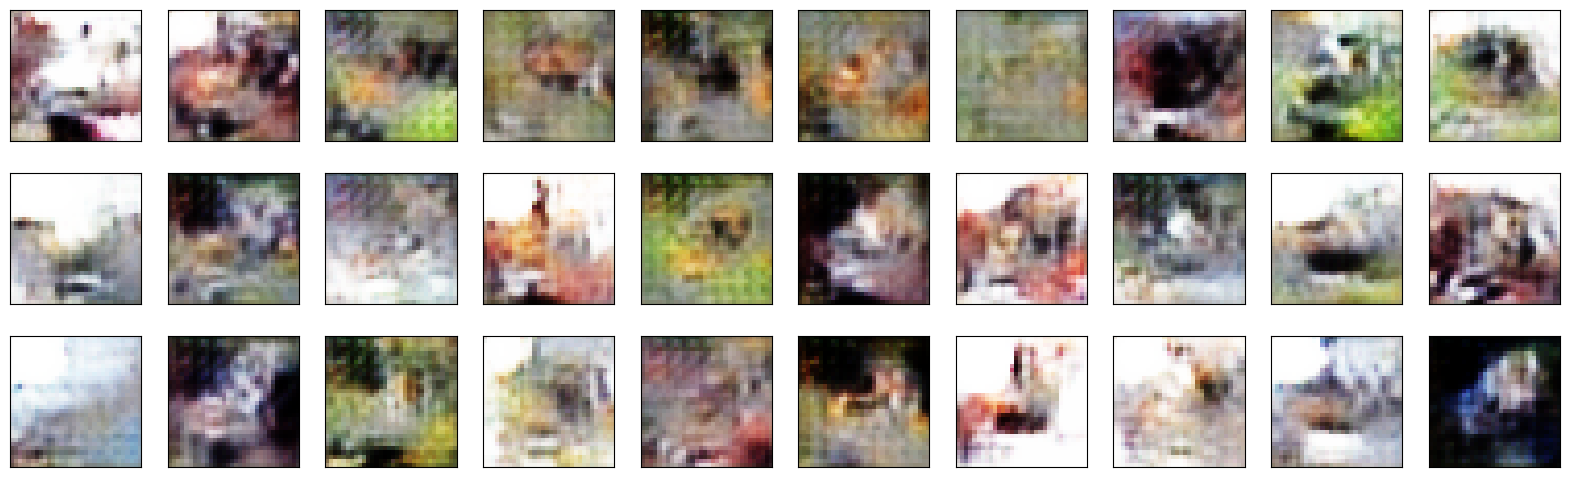

* epoch: 6, d_loss: 344.223577, g_loss: 5302.530477
1/1 [==============================] - 0s 12ms/step


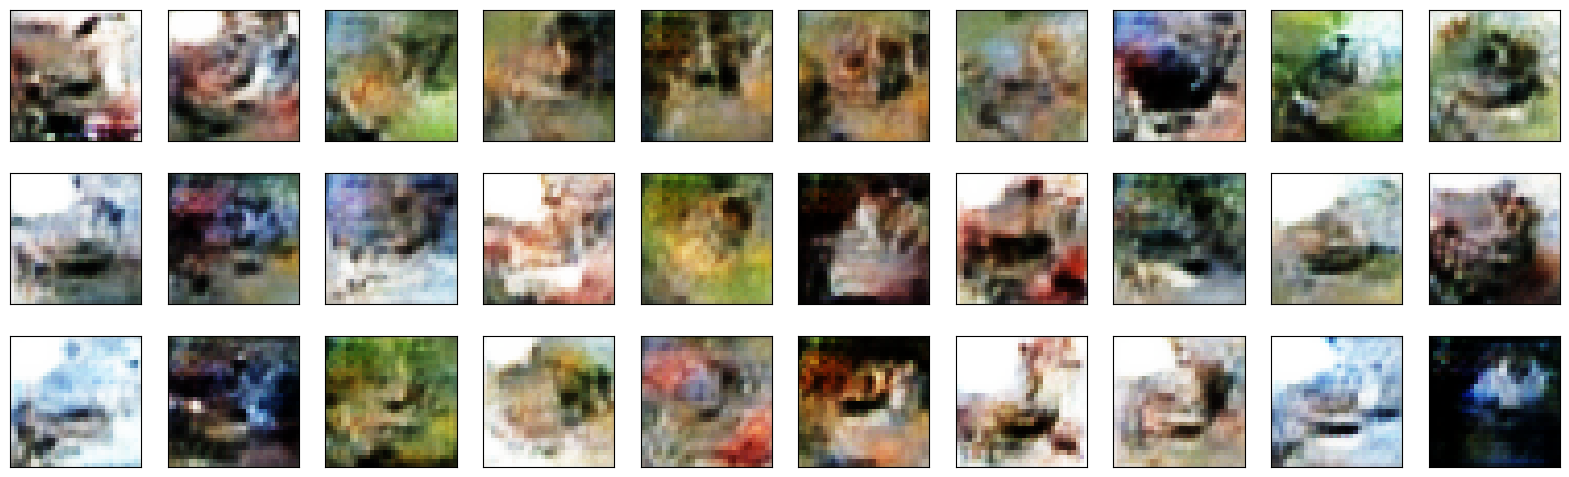

* epoch: 7, d_loss: 363.602469, g_loss: 4996.181960
1/1 [==============================] - 0s 13ms/step


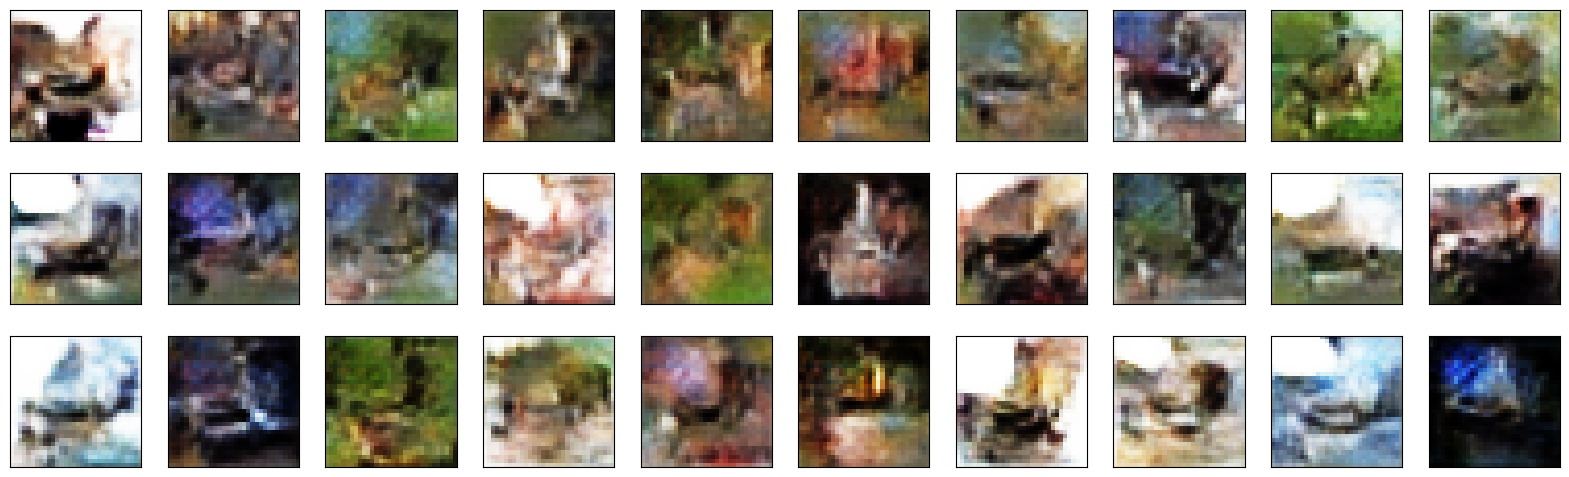

* epoch: 8, d_loss: 360.887317, g_loss: 5058.271848
1/1 [==============================] - 0s 13ms/step


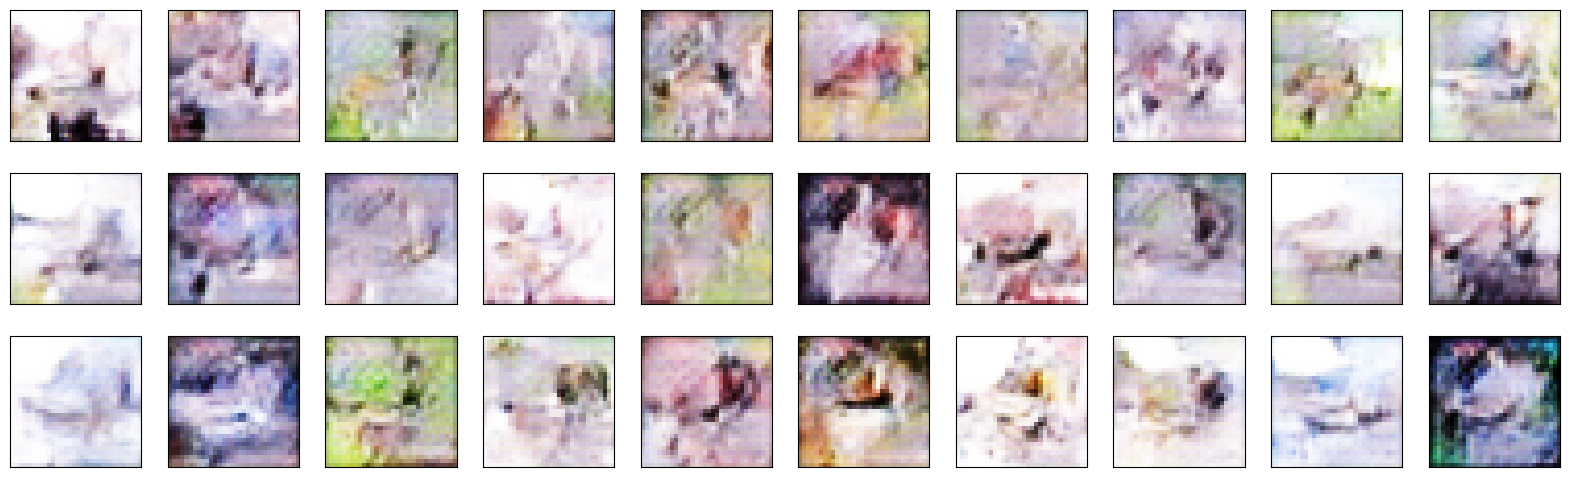

* epoch: 9, d_loss: 352.437854, g_loss: 5151.771303
1/1 [==============================] - 0s 13ms/step


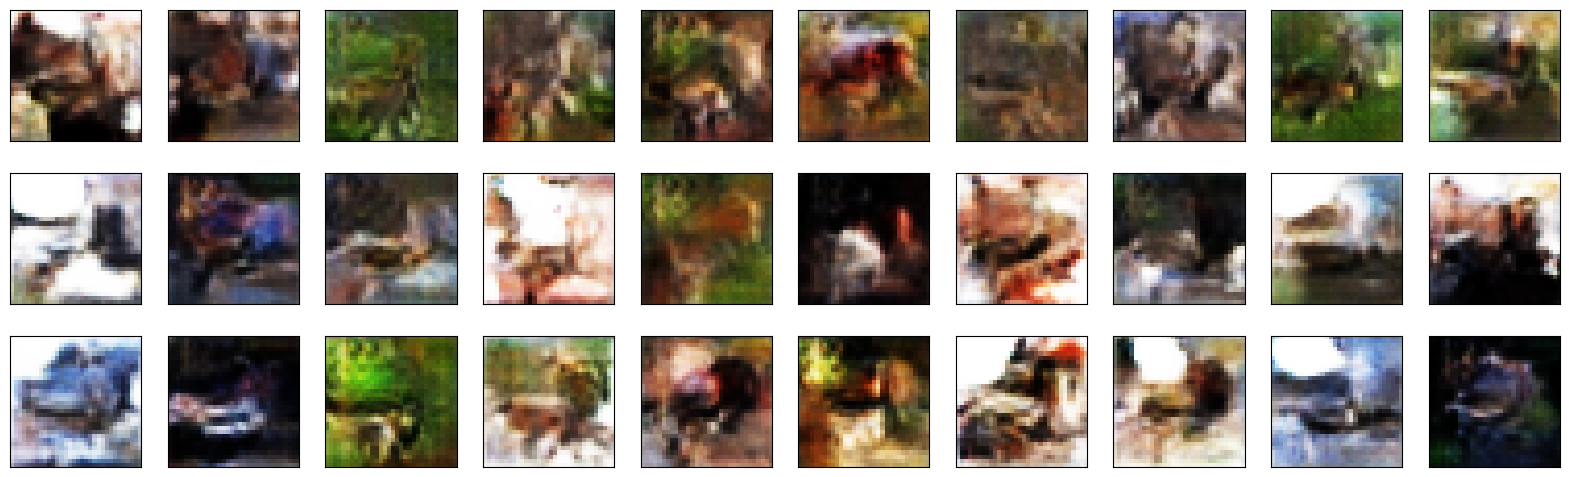

* epoch: 10, d_loss: 393.081960, g_loss: 4667.988392
1/1 [==============================] - 0s 14ms/step


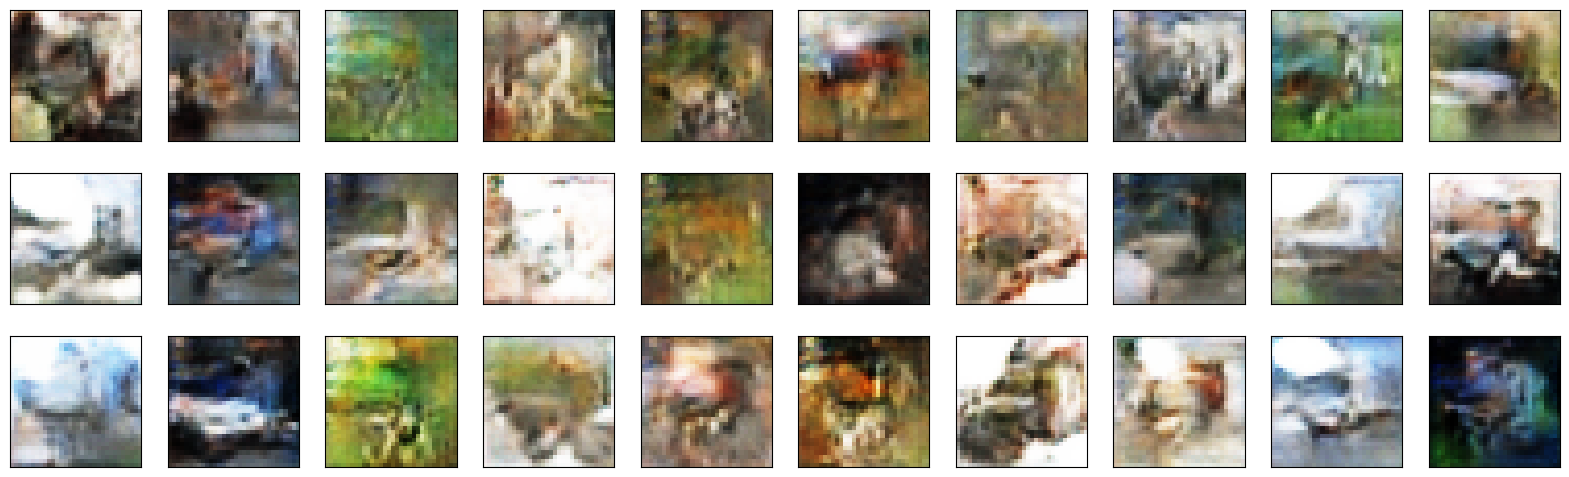

* epoch: 11, d_loss: 385.025527, g_loss: 4731.076512
1/1 [==============================] - 0s 13ms/step


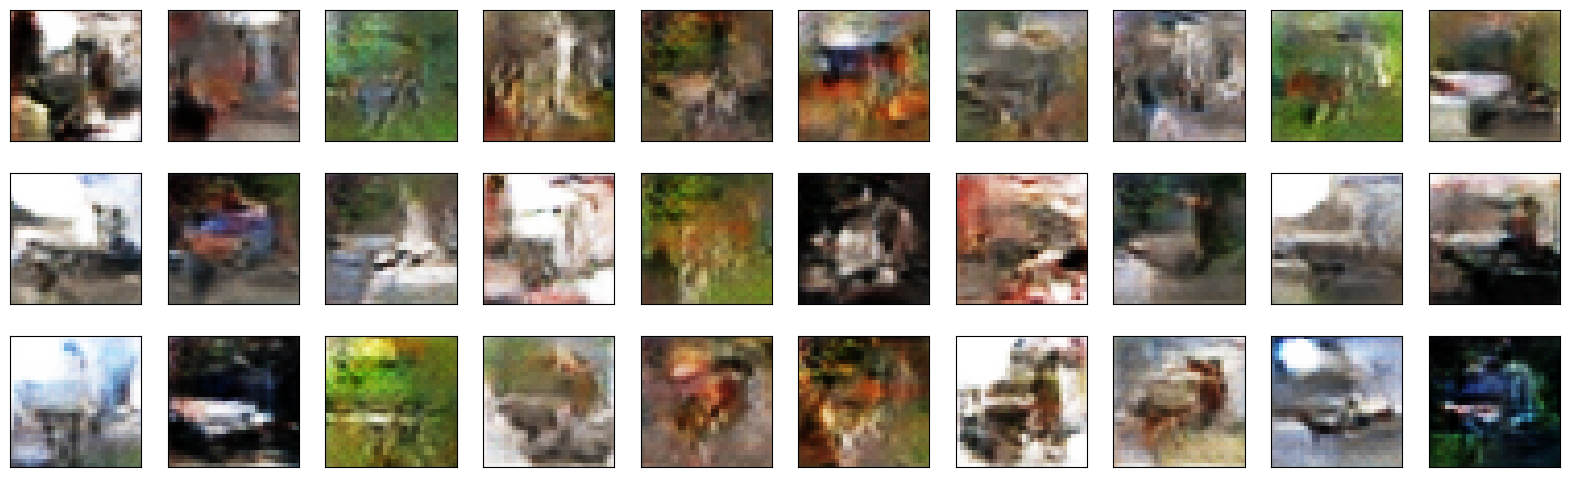

* epoch: 12, d_loss: 399.614164, g_loss: 4565.657329
1/1 [==============================] - 0s 15ms/step


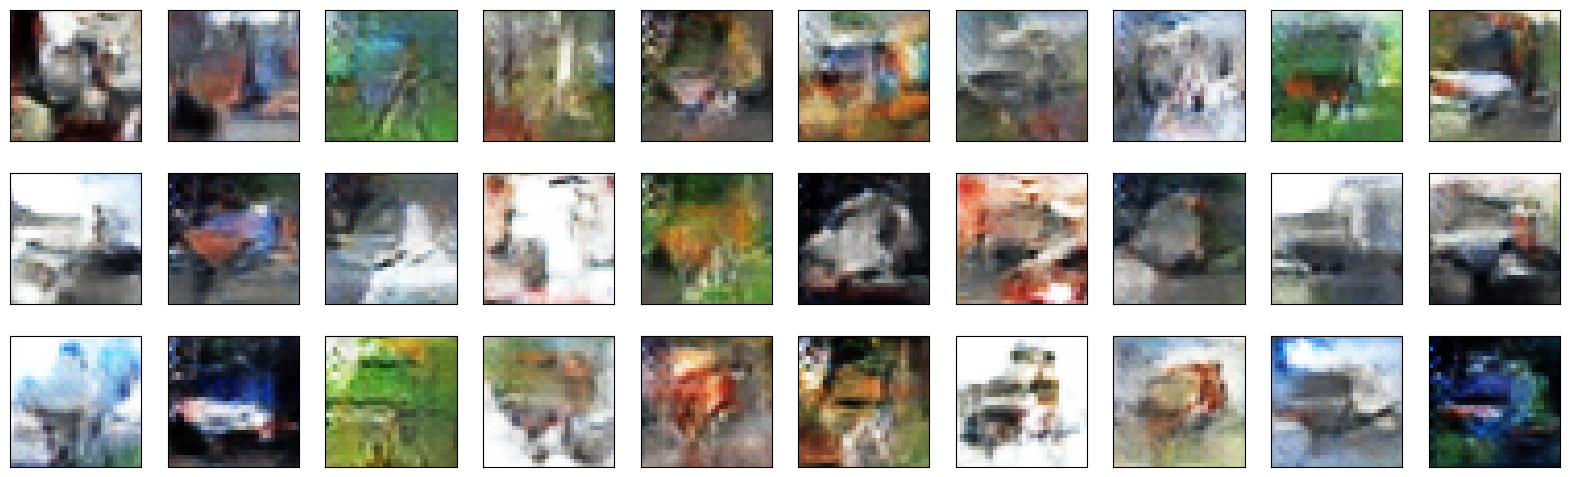

* epoch: 13, d_loss: 363.116091, g_loss: 4906.266095
1/1 [==============================] - 0s 14ms/step


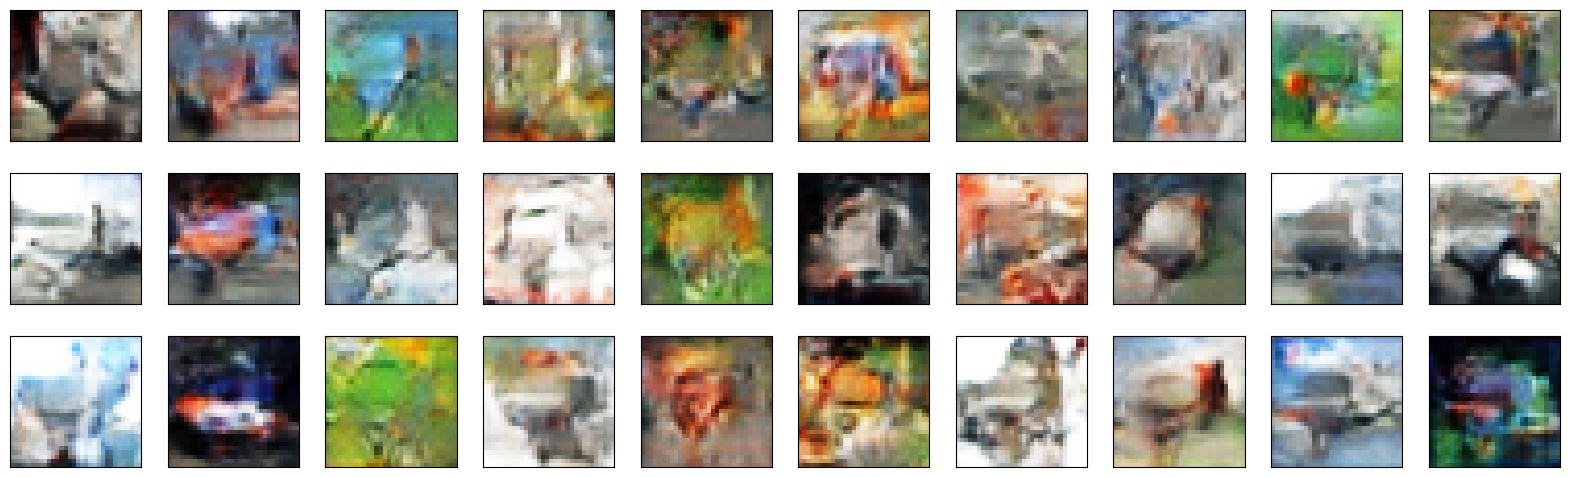

* epoch: 14, d_loss: 408.007956, g_loss: 4414.785929
1/1 [==============================] - 0s 16ms/step


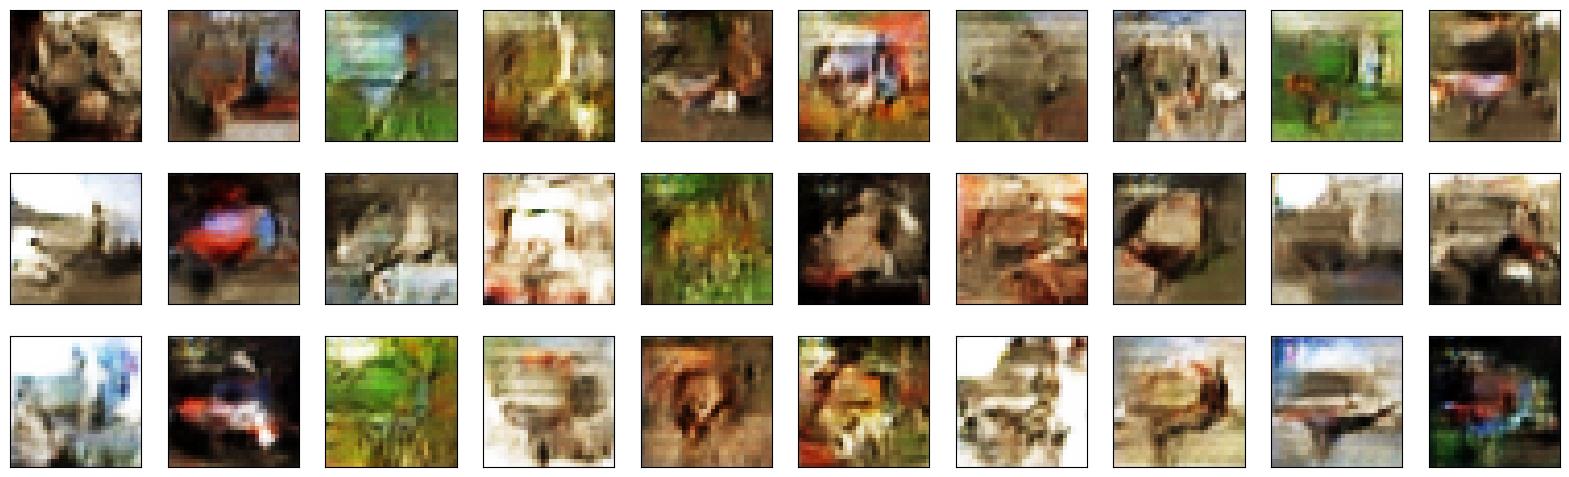

* epoch: 15, d_loss: 380.061312, g_loss: 4751.750680
1/1 [==============================] - 0s 15ms/step


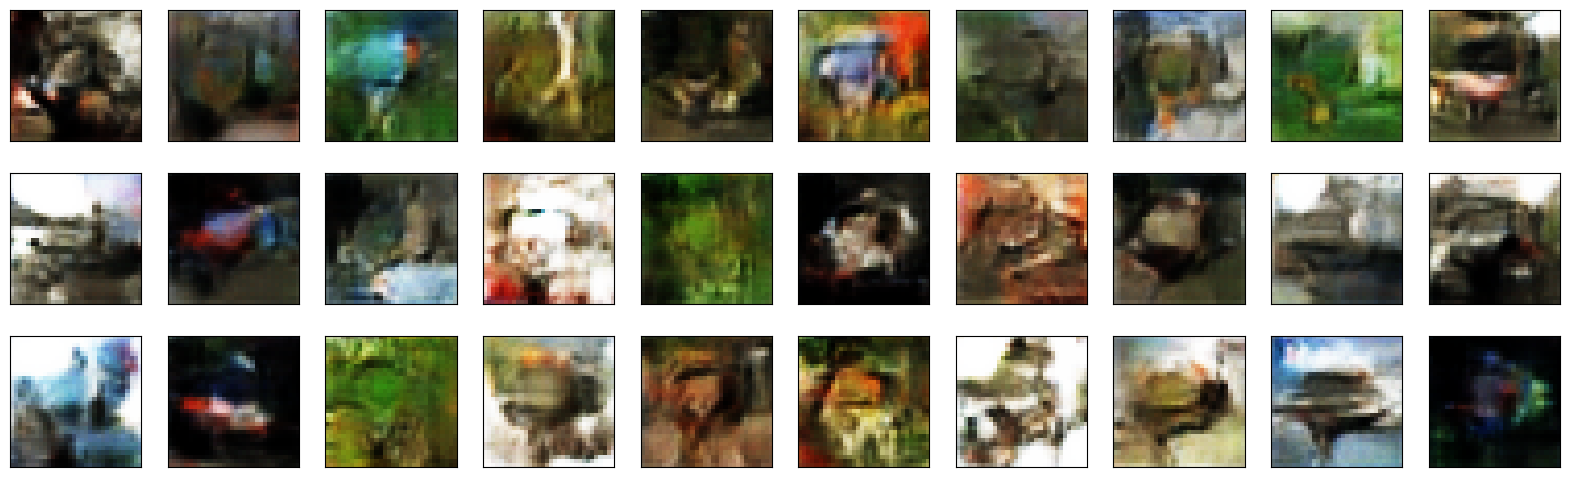

* epoch: 16, d_loss: 391.279051, g_loss: 4580.265579
1/1 [==============================] - 0s 14ms/step


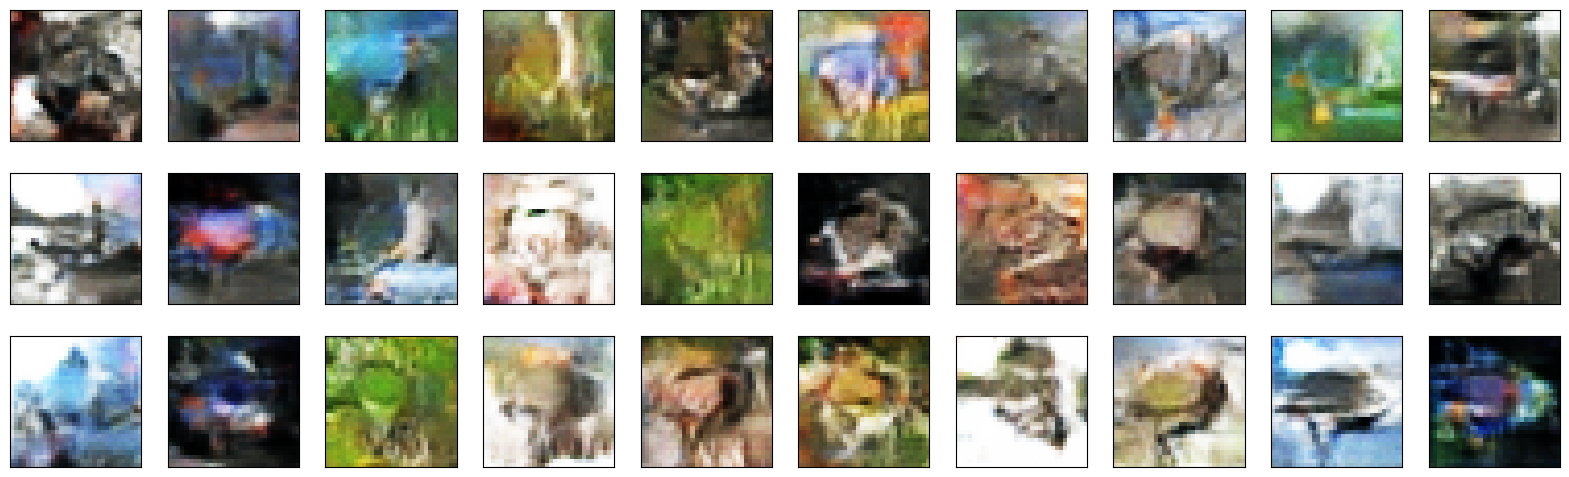

* epoch: 17, d_loss: 385.794925, g_loss: 4699.467197
1/1 [==============================] - 0s 14ms/step


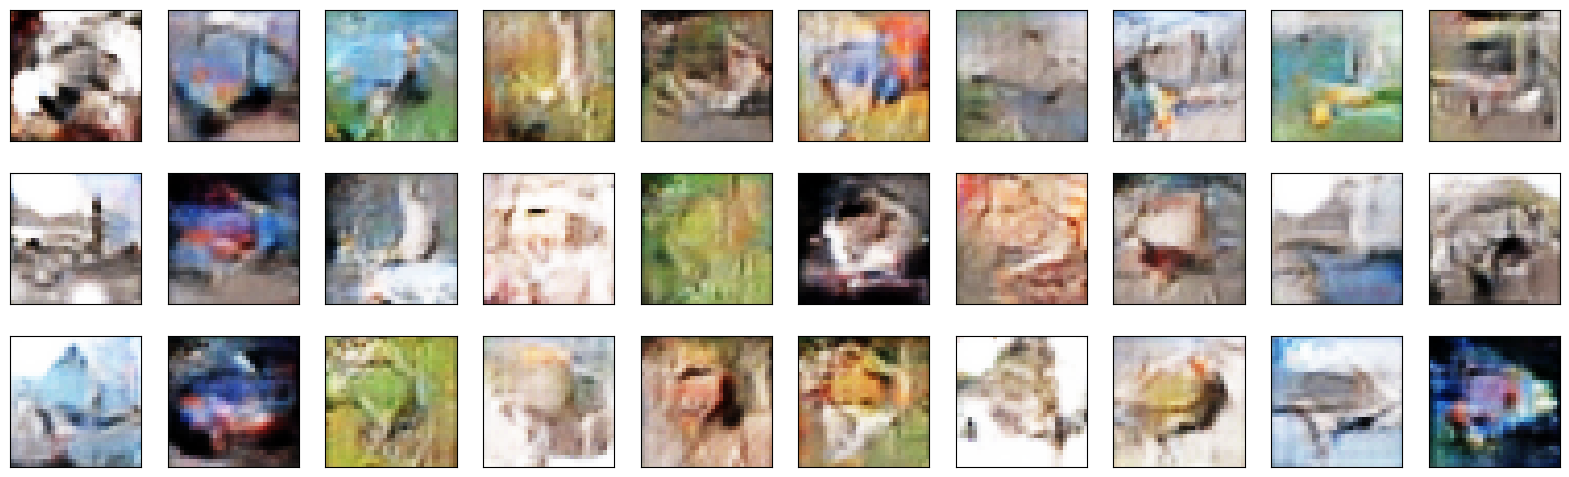

* epoch: 18, d_loss: 414.137288, g_loss: 4344.305519
1/1 [==============================] - 0s 14ms/step


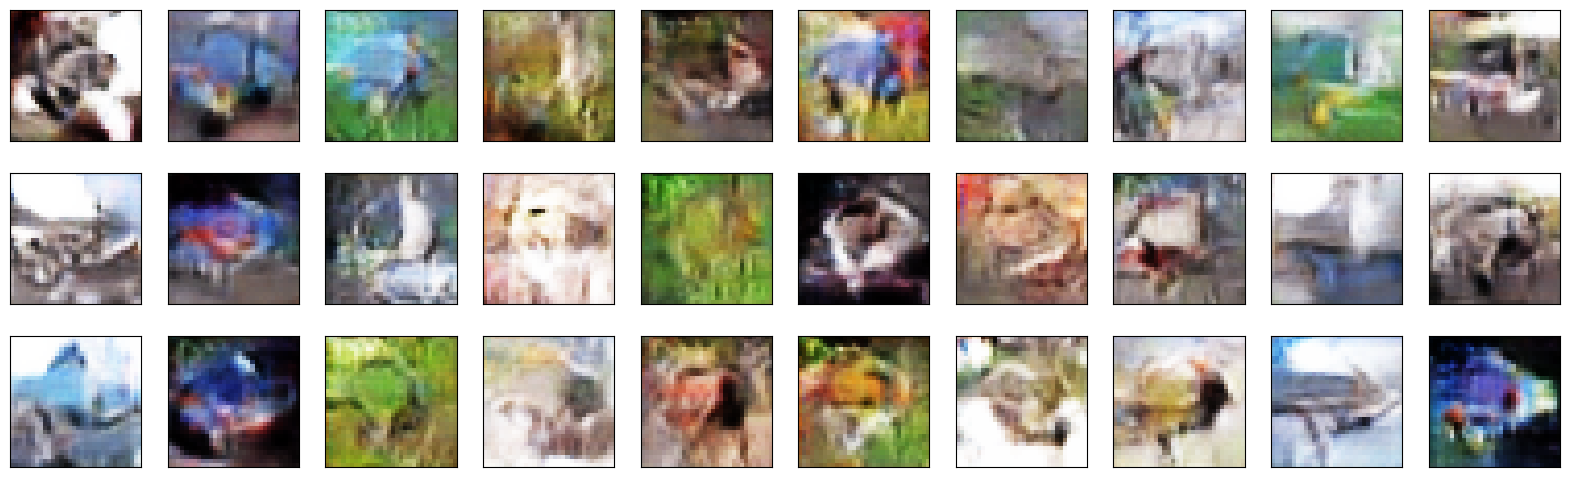

* epoch: 19, d_loss: 450.744254, g_loss: 4027.530230
1/1 [==============================] - 0s 16ms/step


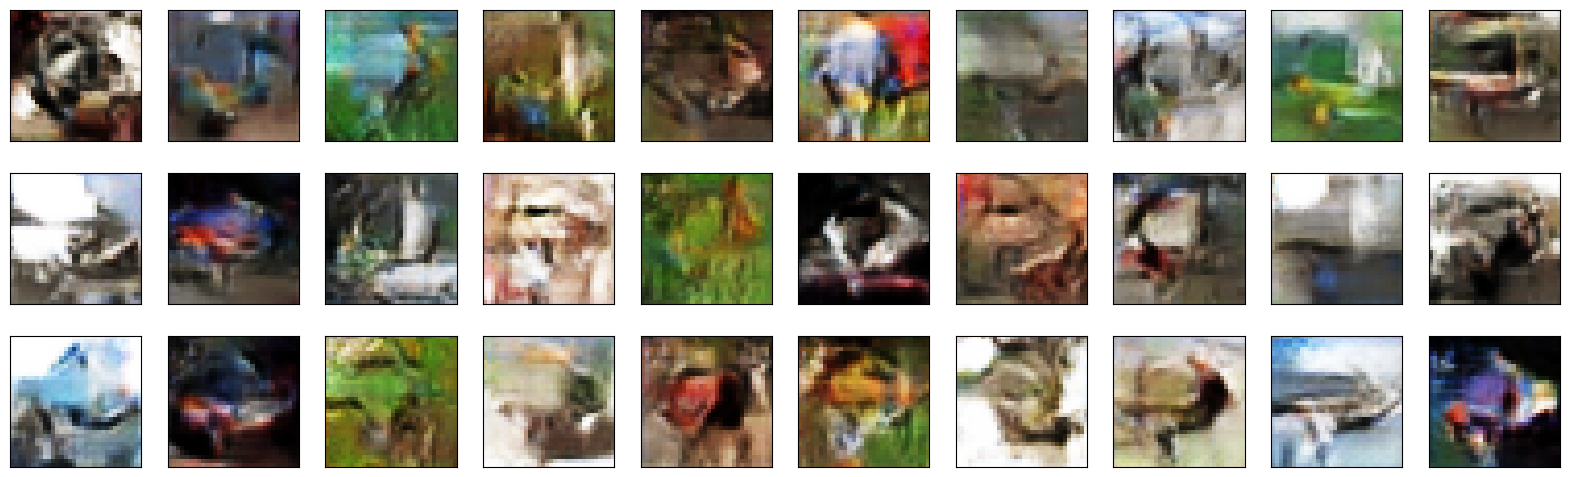

* epoch: 20, d_loss: 398.441793, g_loss: 4707.110306
1/1 [==============================] - 0s 14ms/step


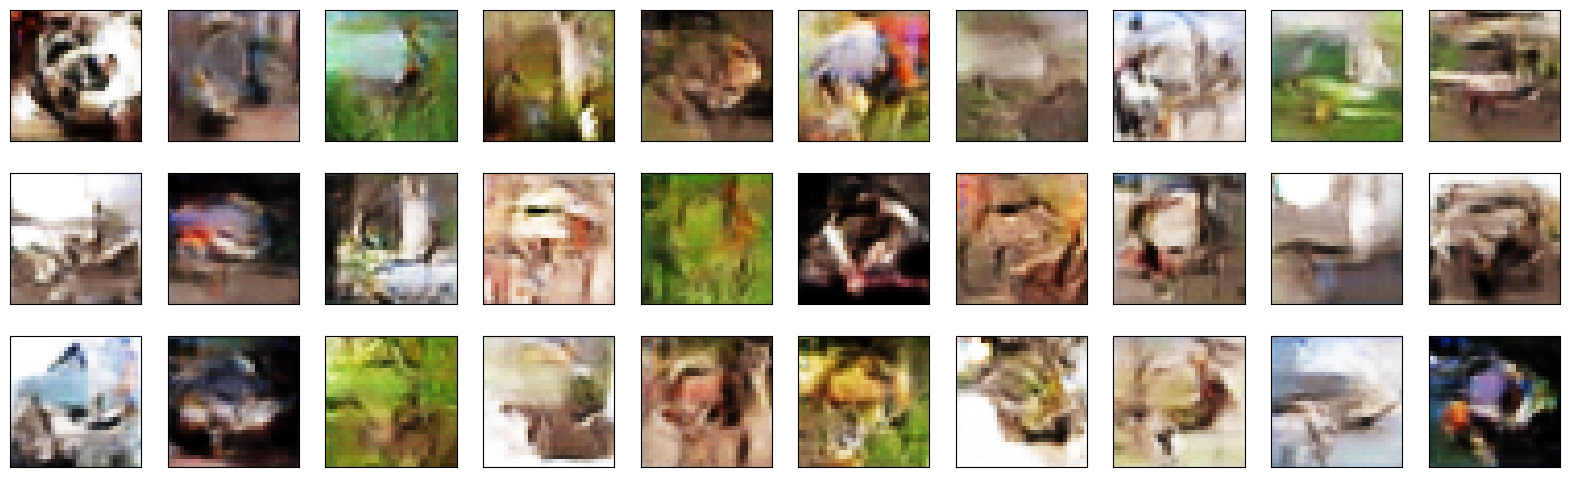

* epoch: 21, d_loss: 434.248325, g_loss: 4247.217969
1/1 [==============================] - 0s 15ms/step


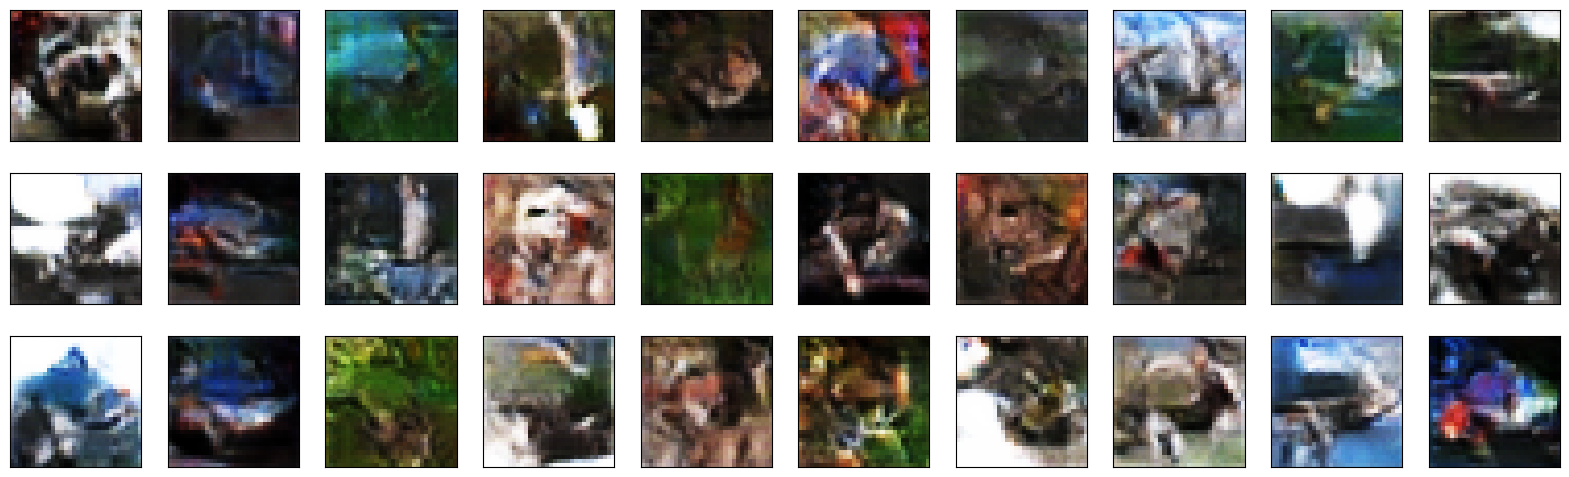

* epoch: 22, d_loss: 444.076654, g_loss: 4053.555914
1/1 [==============================] - 0s 18ms/step


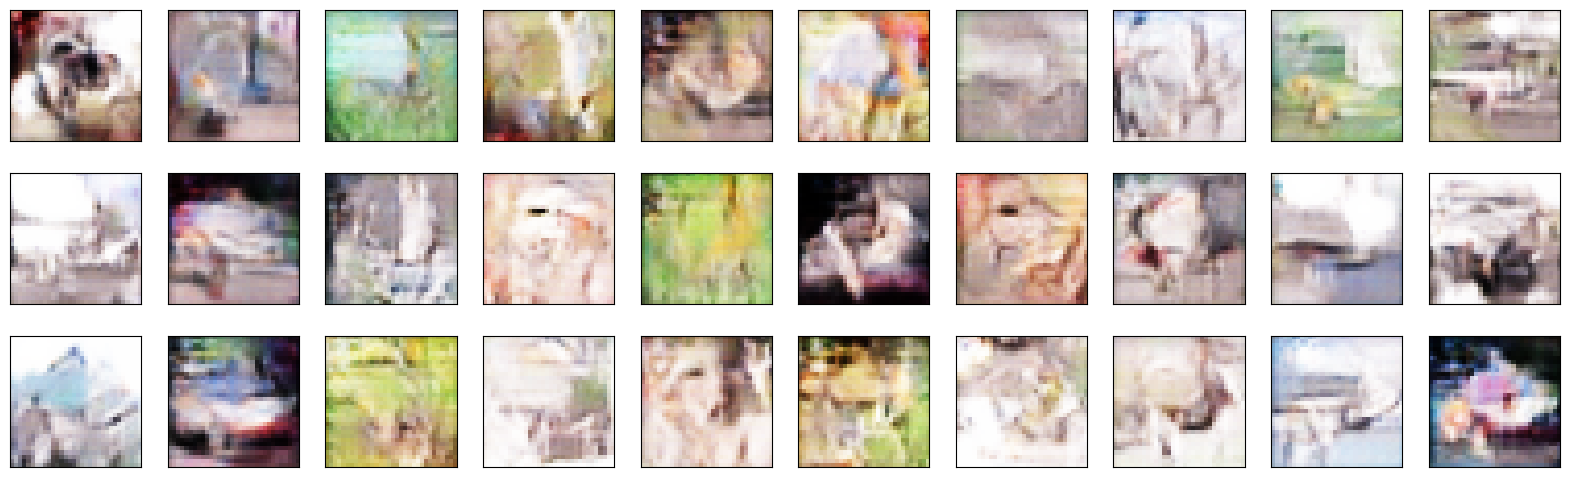

* epoch: 23, d_loss: 447.779714, g_loss: 4088.898192
1/1 [==============================] - 0s 16ms/step


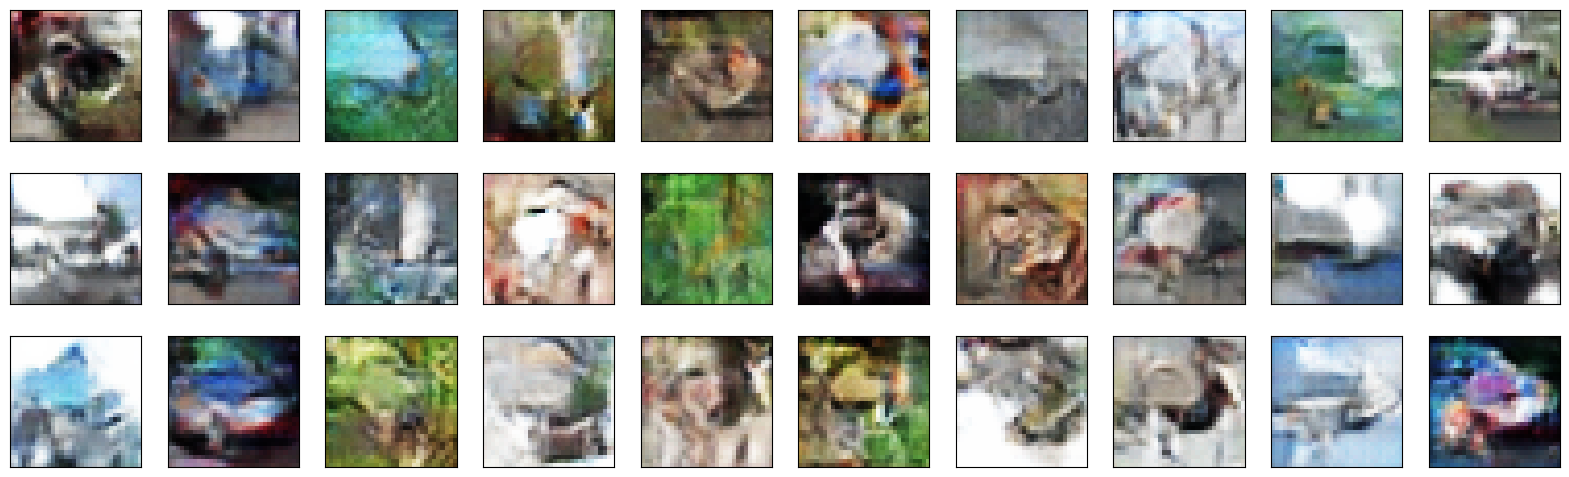

* epoch: 24, d_loss: 473.284415, g_loss: 3880.724335
1/1 [==============================] - 0s 15ms/step


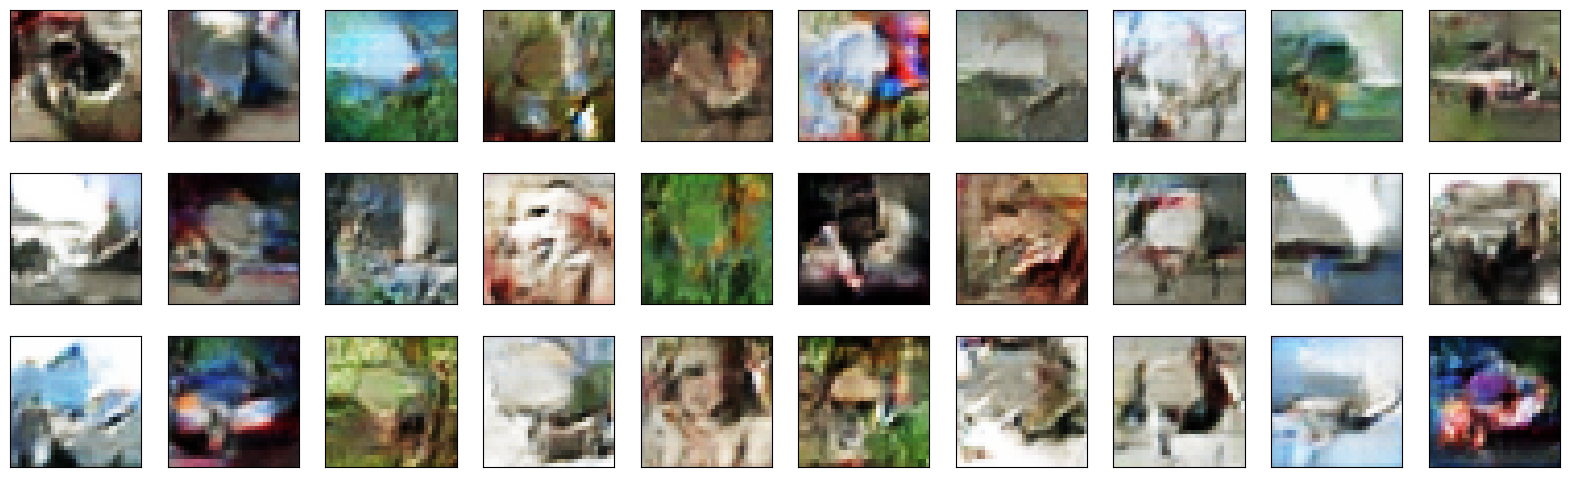

* epoch: 25, d_loss: 425.335487, g_loss: 4432.008095
1/1 [==============================] - 0s 15ms/step


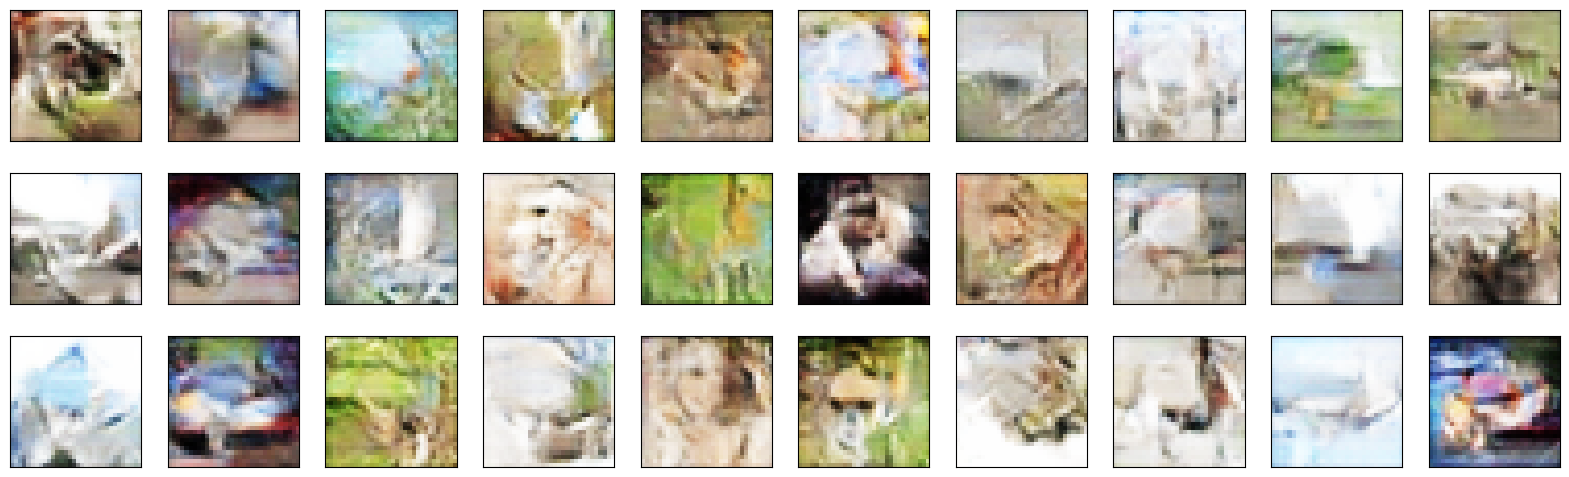

* epoch: 26, d_loss: 431.779102, g_loss: 4463.705099
1/1 [==============================] - 0s 14ms/step


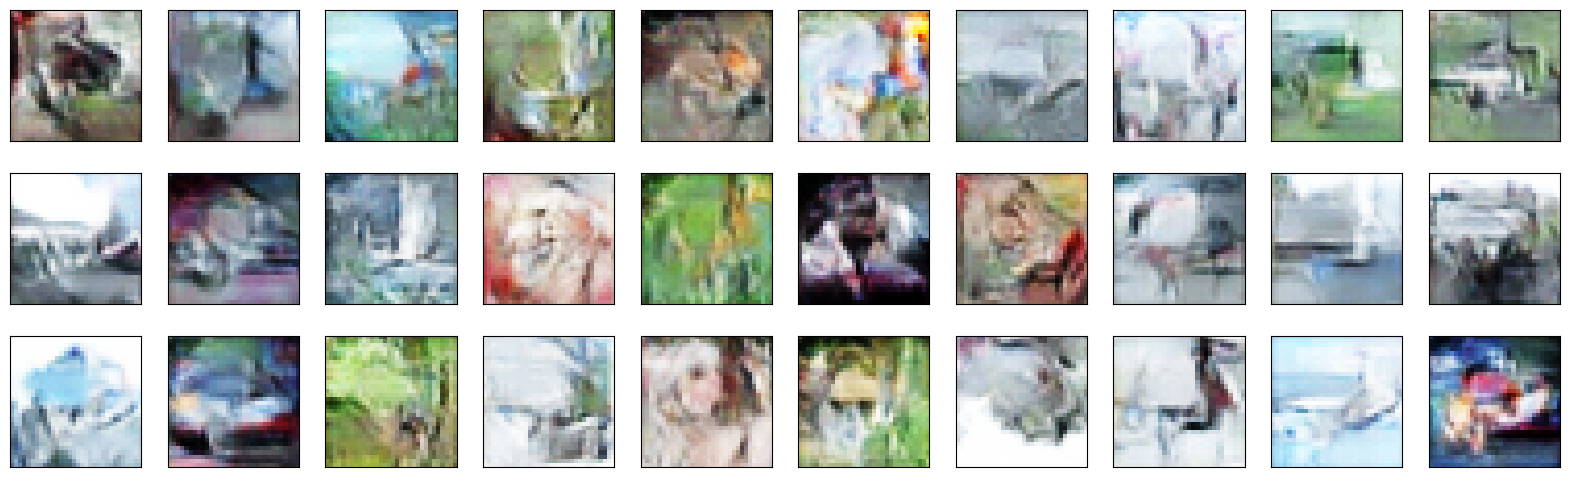

* epoch: 27, d_loss: 442.780649, g_loss: 4187.480190
1/1 [==============================] - 0s 15ms/step


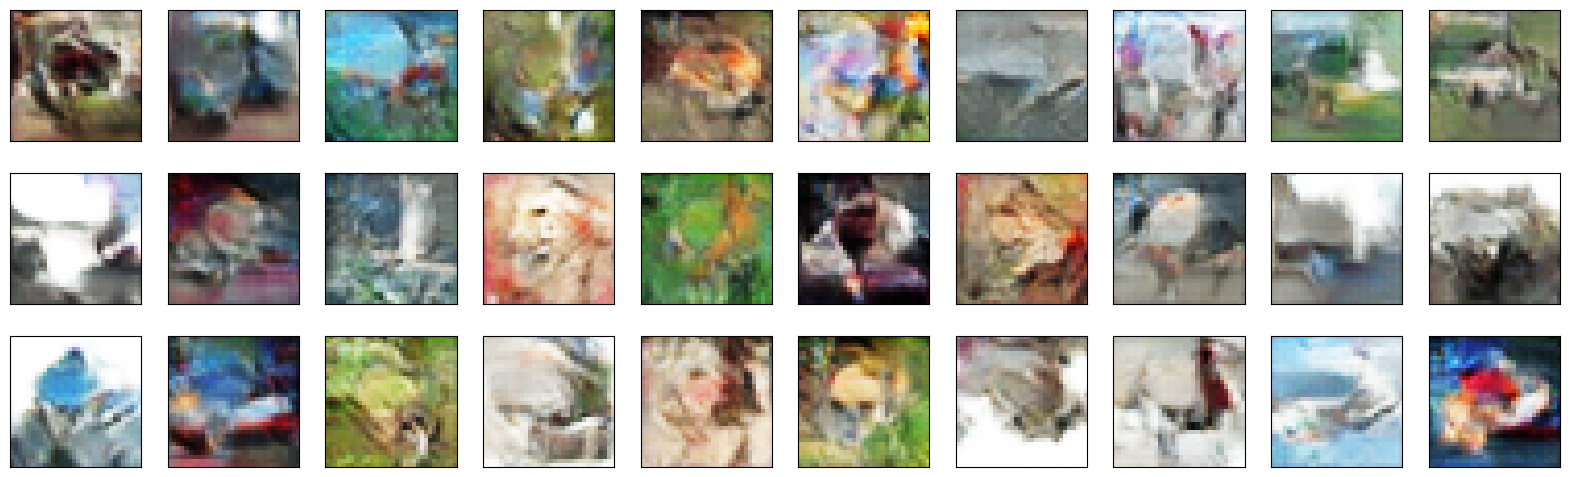

* epoch: 28, d_loss: 452.975566, g_loss: 4146.227864
1/1 [==============================] - 0s 15ms/step


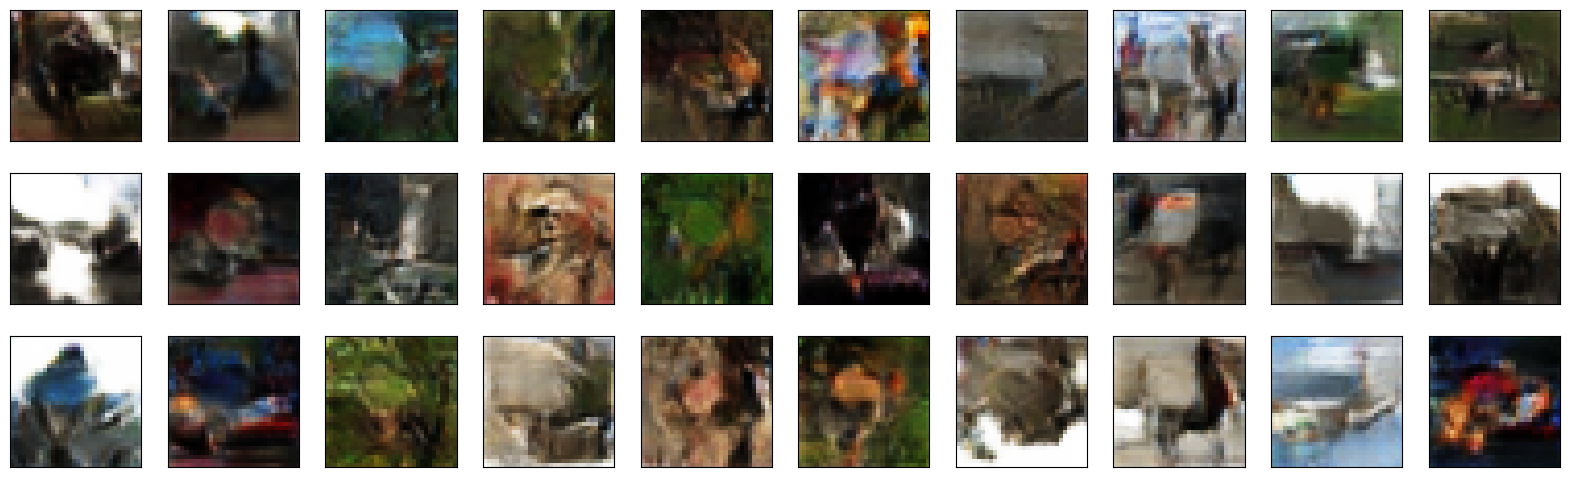

* epoch: 29, d_loss: 418.383136, g_loss: 4519.336943
1/1 [==============================] - 0s 14ms/step


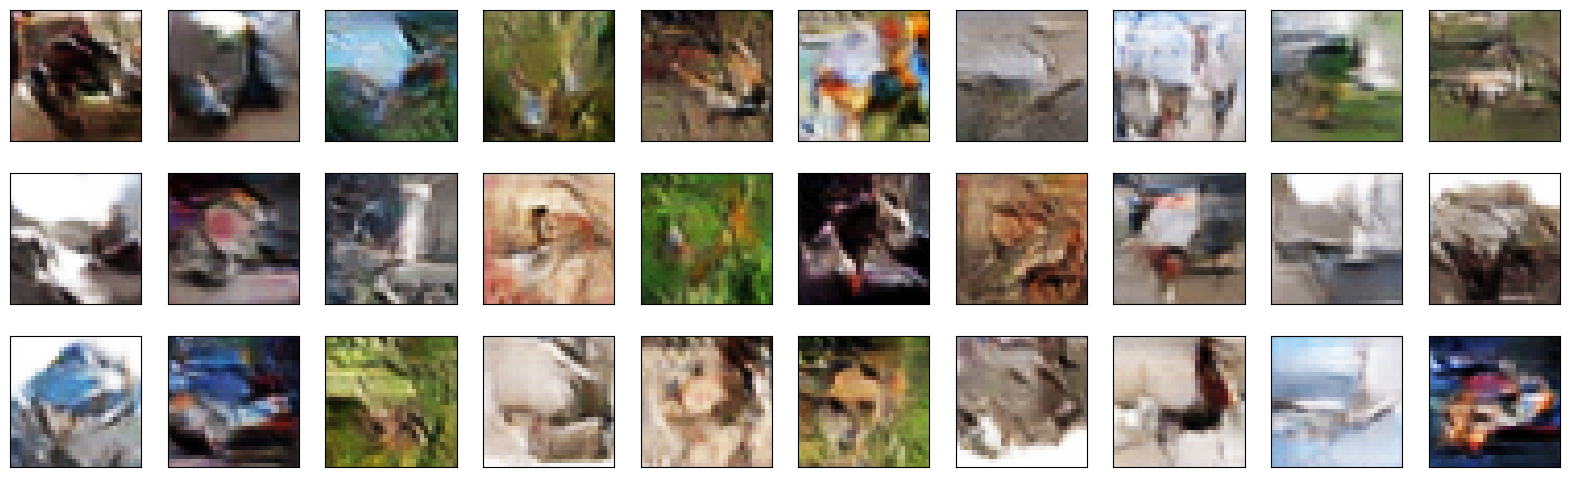

* epoch: 30, d_loss: 432.391213, g_loss: 4432.859711
1/1 [==============================] - 0s 15ms/step


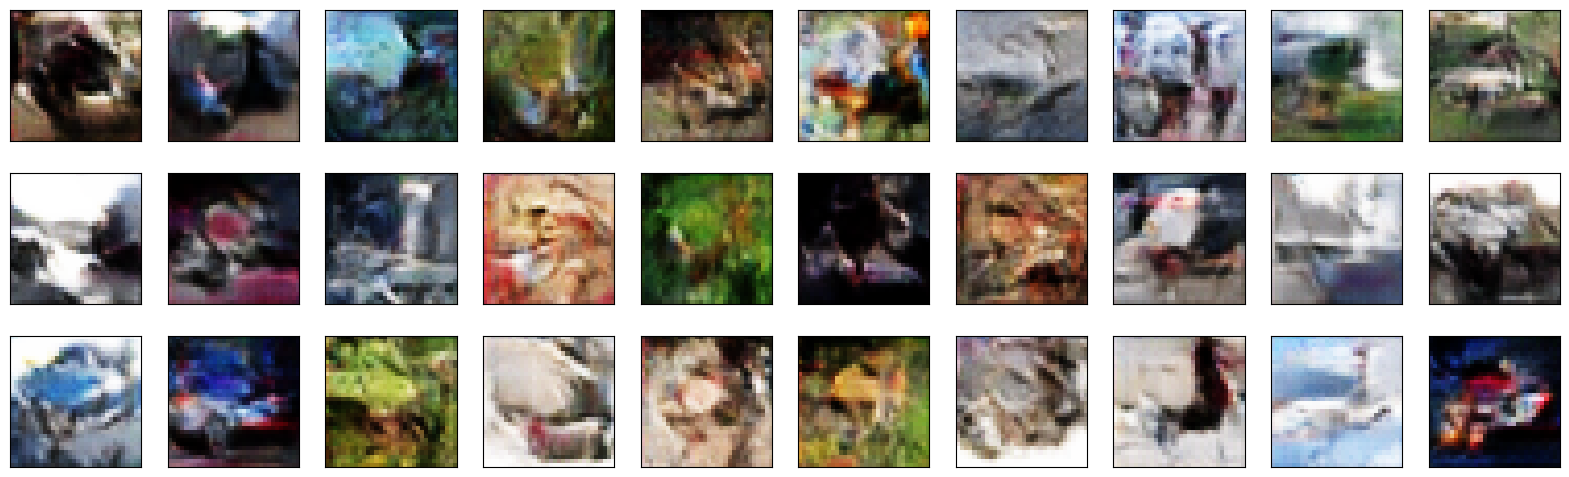

* epoch: 31, d_loss: 452.650854, g_loss: 4173.597488
1/1 [==============================] - 0s 14ms/step


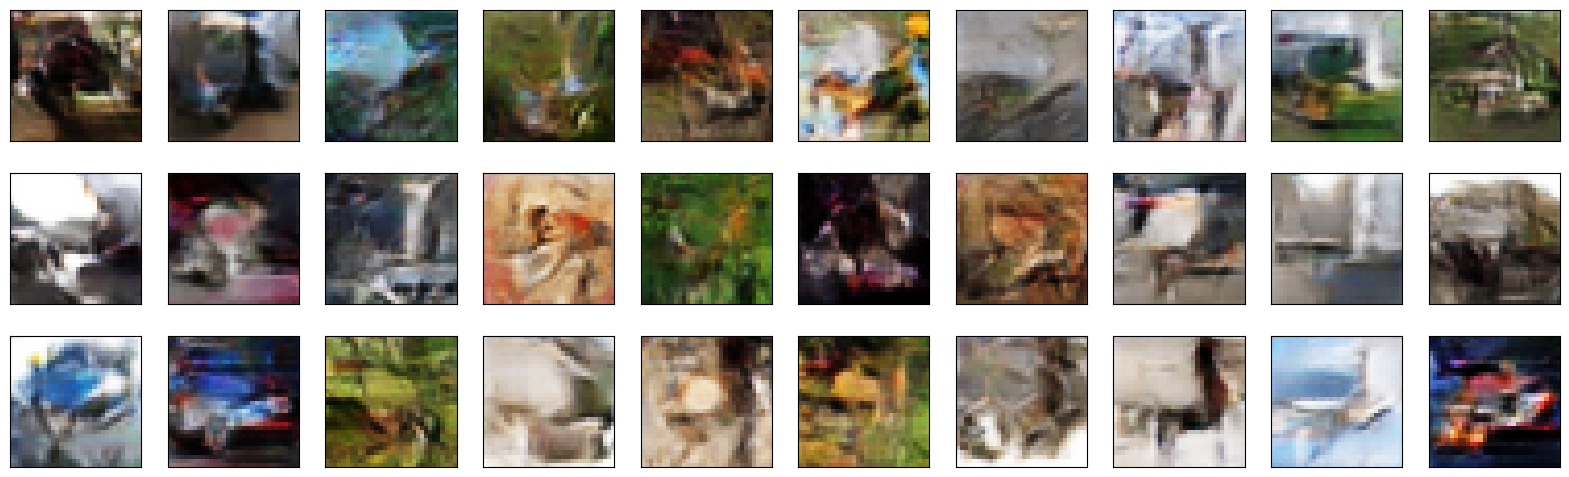

* epoch: 32, d_loss: 453.569985, g_loss: 4120.452165
1/1 [==============================] - 0s 14ms/step


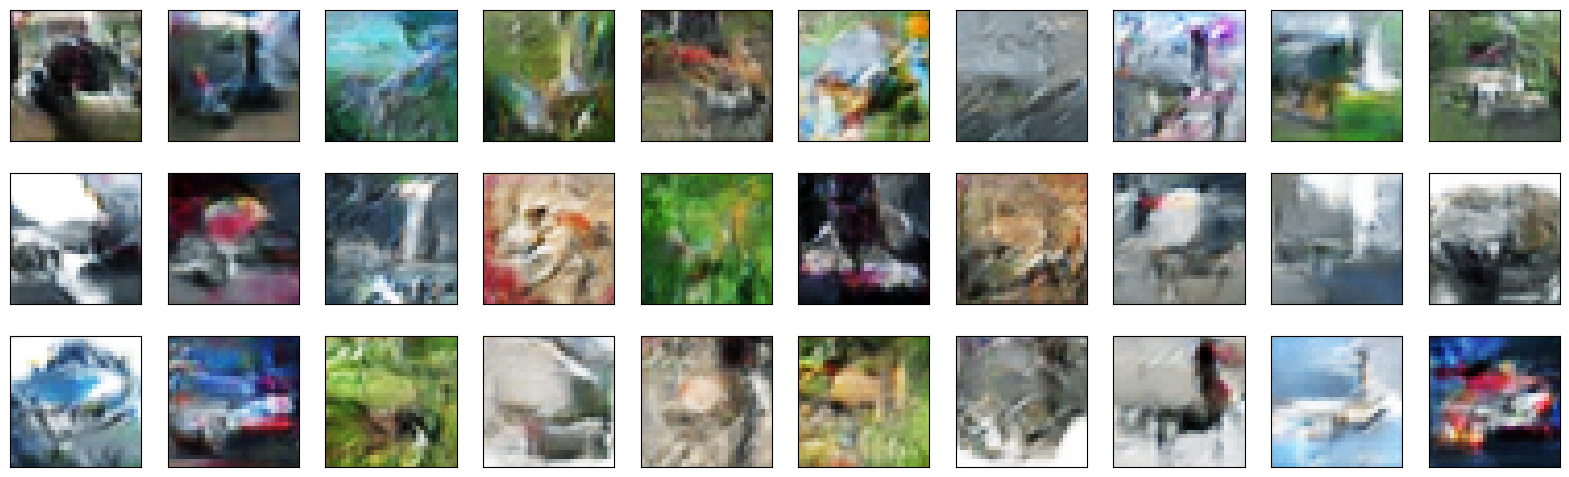

* epoch: 33, d_loss: 476.953558, g_loss: 3896.088517
1/1 [==============================] - 0s 15ms/step


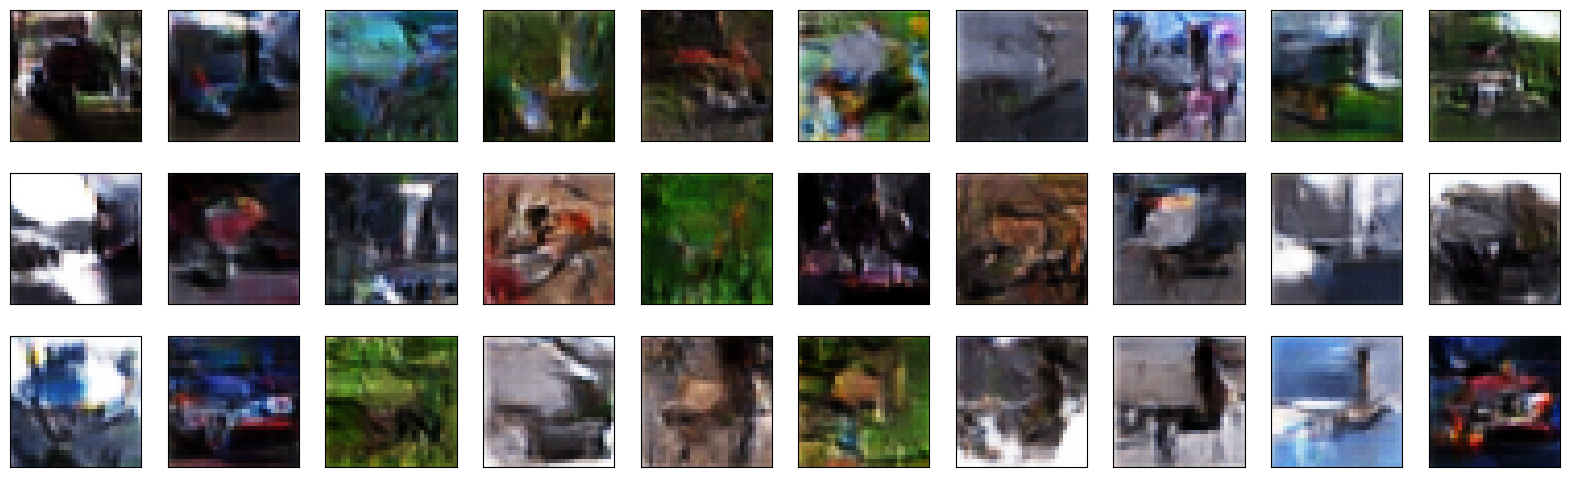

* epoch: 34, d_loss: 446.604842, g_loss: 4215.087273
1/1 [==============================] - 0s 18ms/step


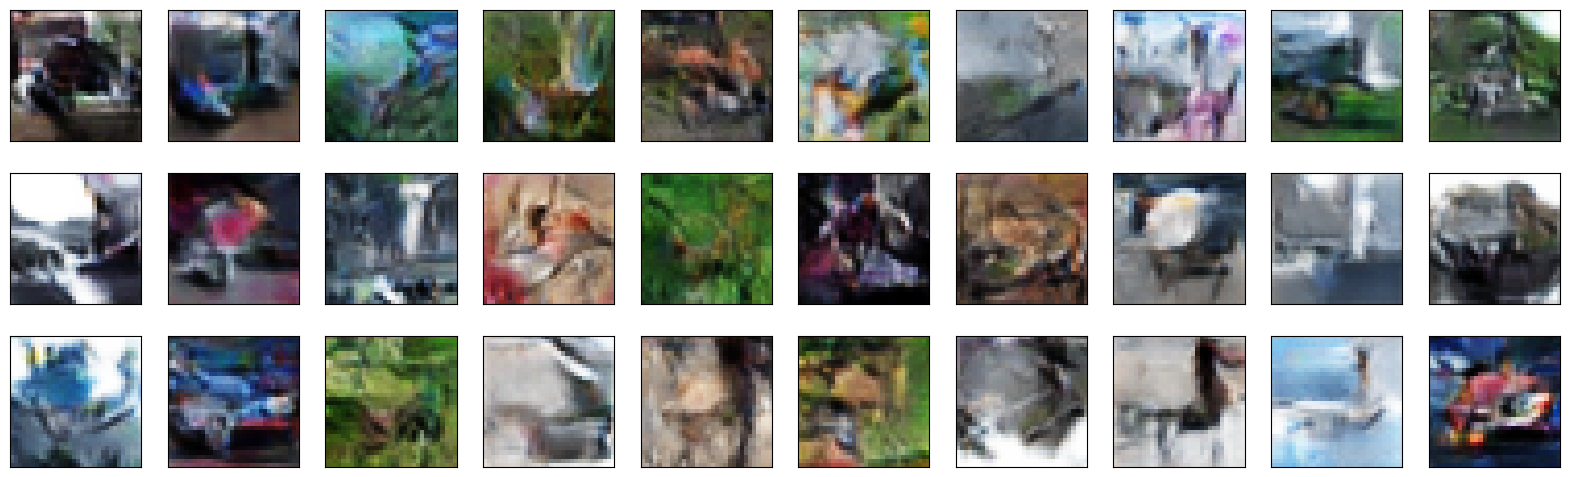

* epoch: 35, d_loss: 460.731551, g_loss: 4079.033830
1/1 [==============================] - 0s 17ms/step


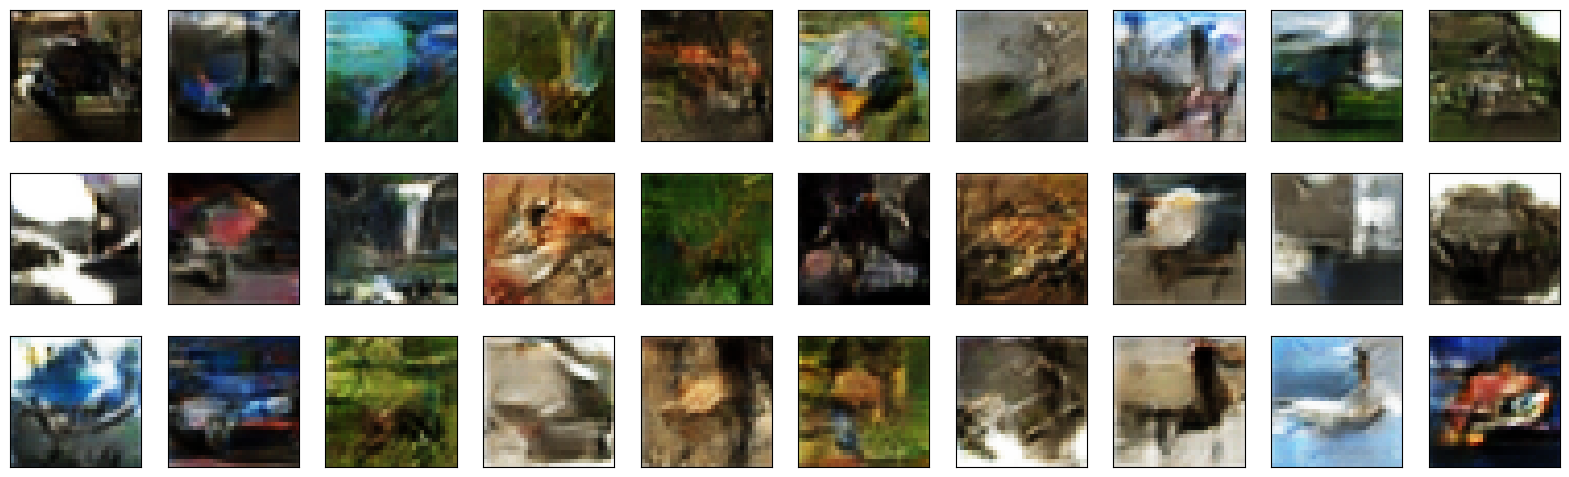

* epoch: 36, d_loss: 439.510494, g_loss: 4336.487697
1/1 [==============================] - 0s 16ms/step


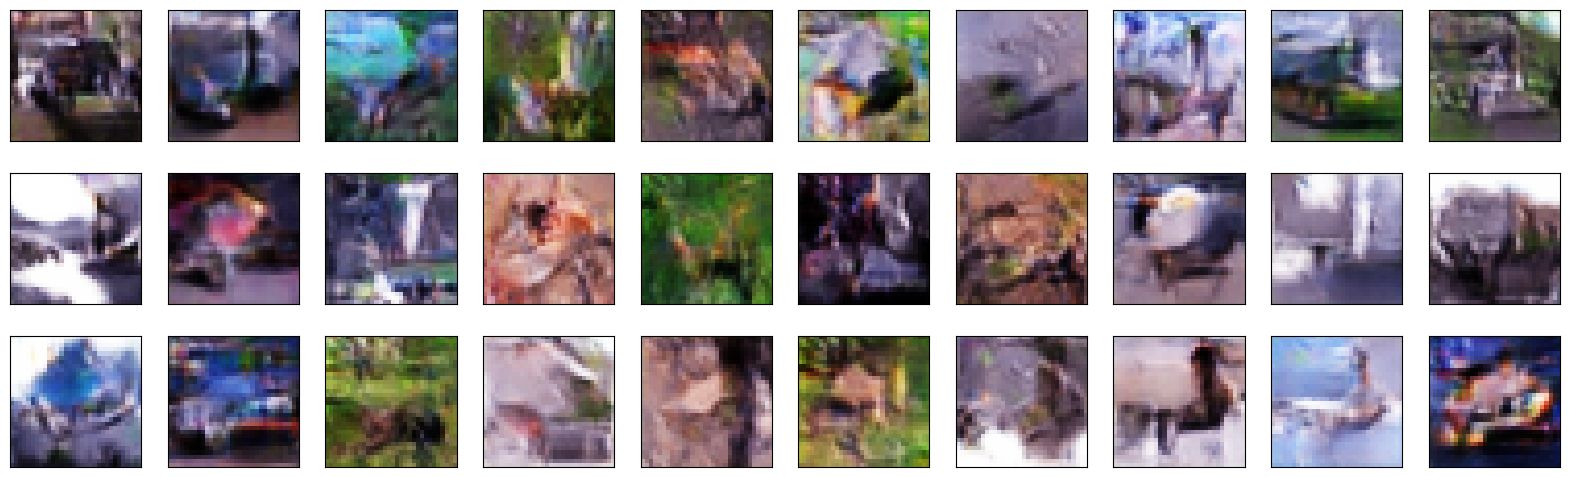

* epoch: 37, d_loss: 472.246056, g_loss: 4024.304802
1/1 [==============================] - 0s 17ms/step


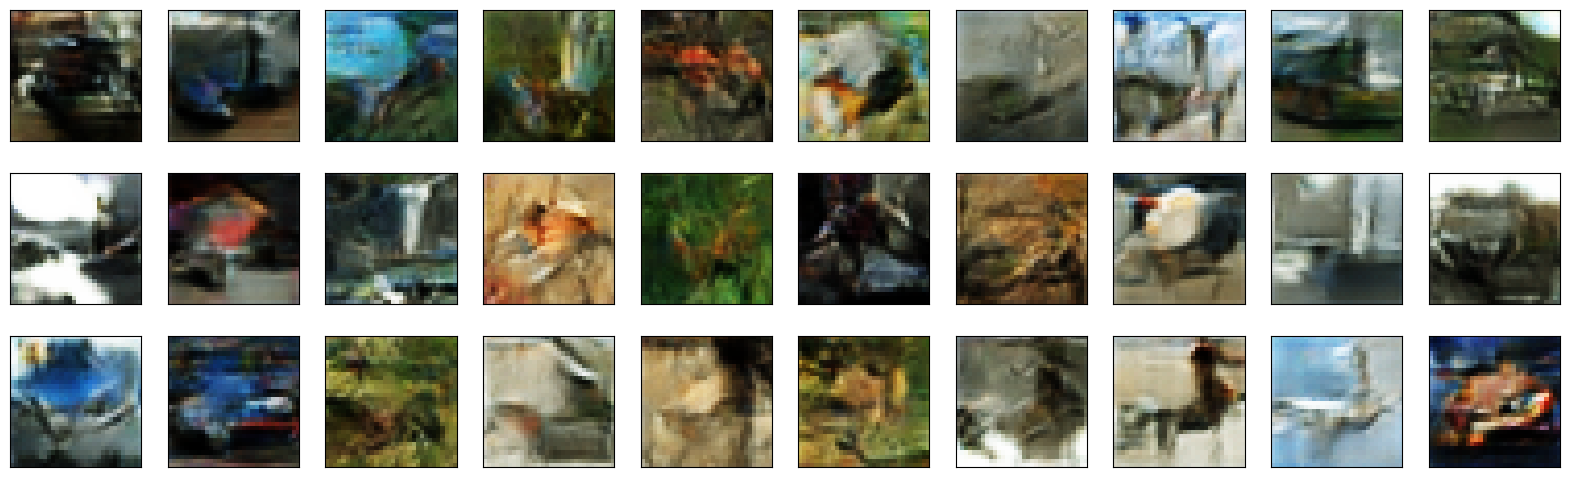

* epoch: 38, d_loss: 459.950616, g_loss: 4113.761219
1/1 [==============================] - 0s 15ms/step


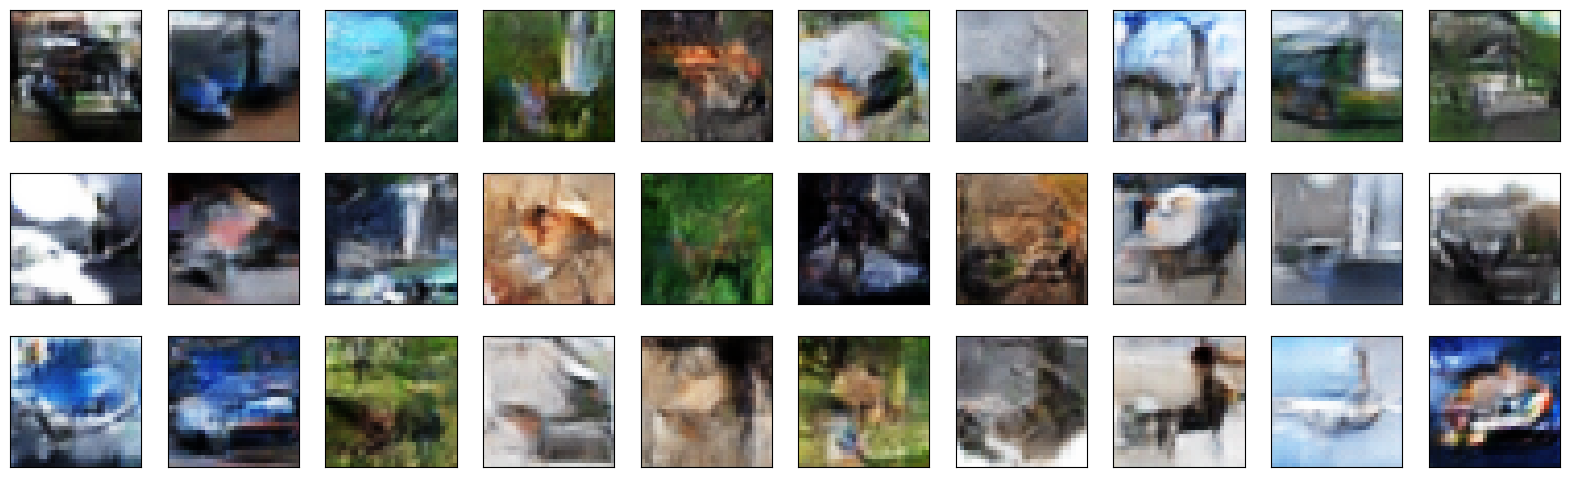

* epoch: 39, d_loss: 476.101431, g_loss: 4012.747767
1/1 [==============================] - 0s 17ms/step


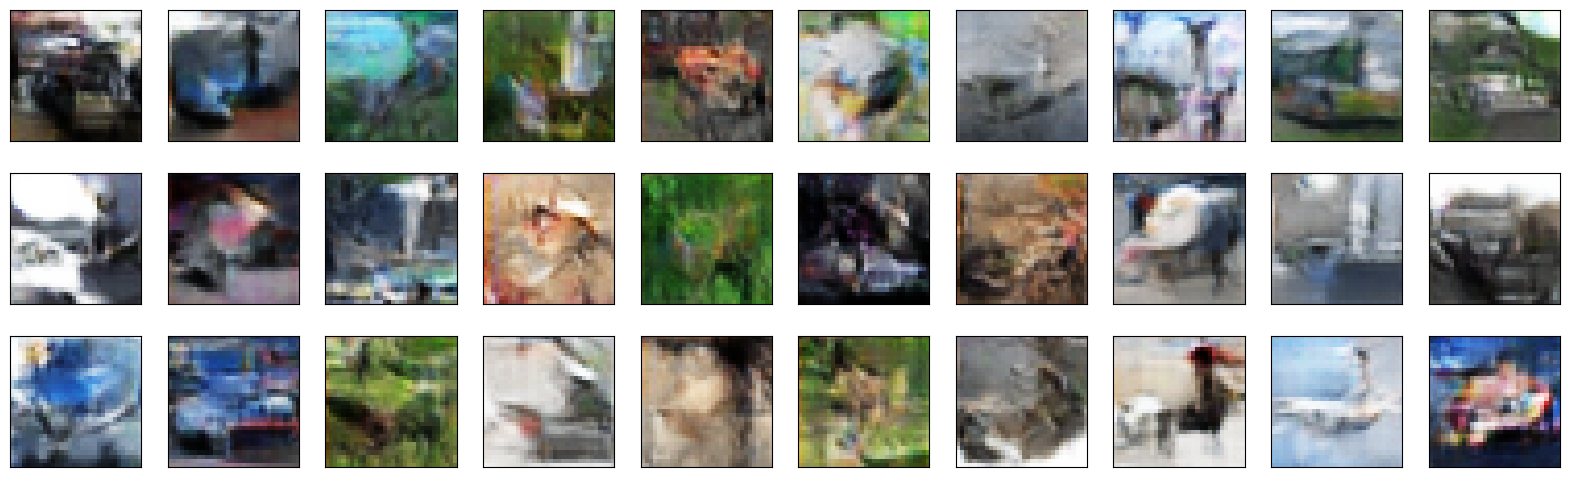

* epoch: 40, d_loss: 457.676605, g_loss: 4148.505342
1/1 [==============================] - 0s 14ms/step


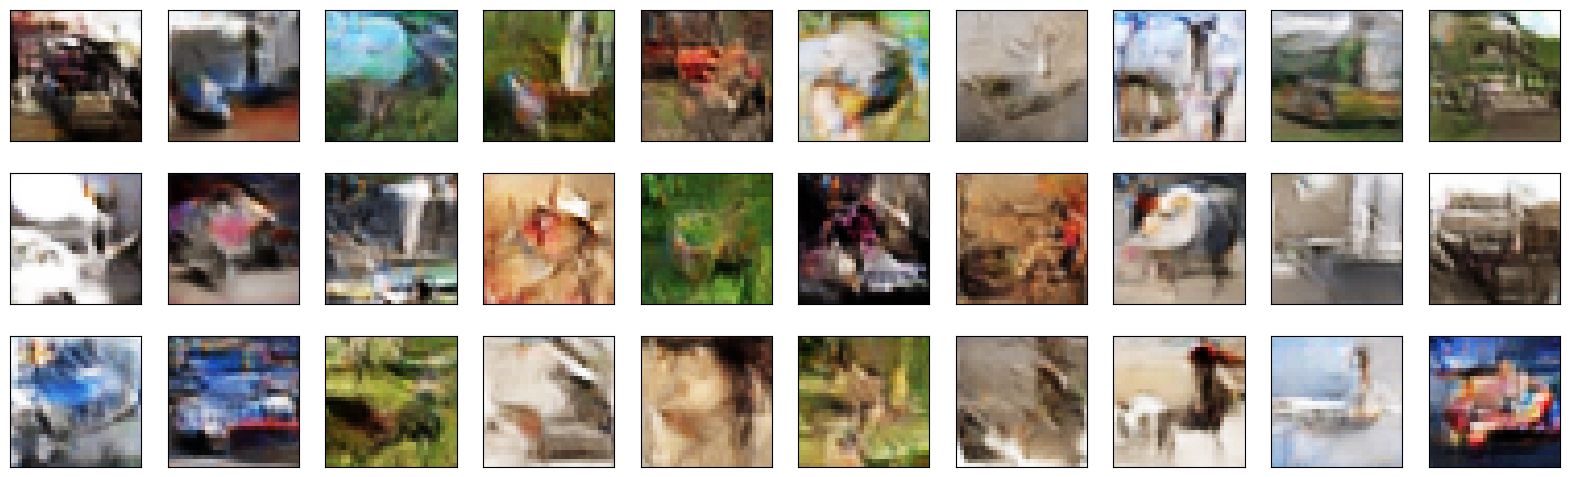

* epoch: 41, d_loss: 437.446840, g_loss: 4360.913341
1/1 [==============================] - 0s 18ms/step


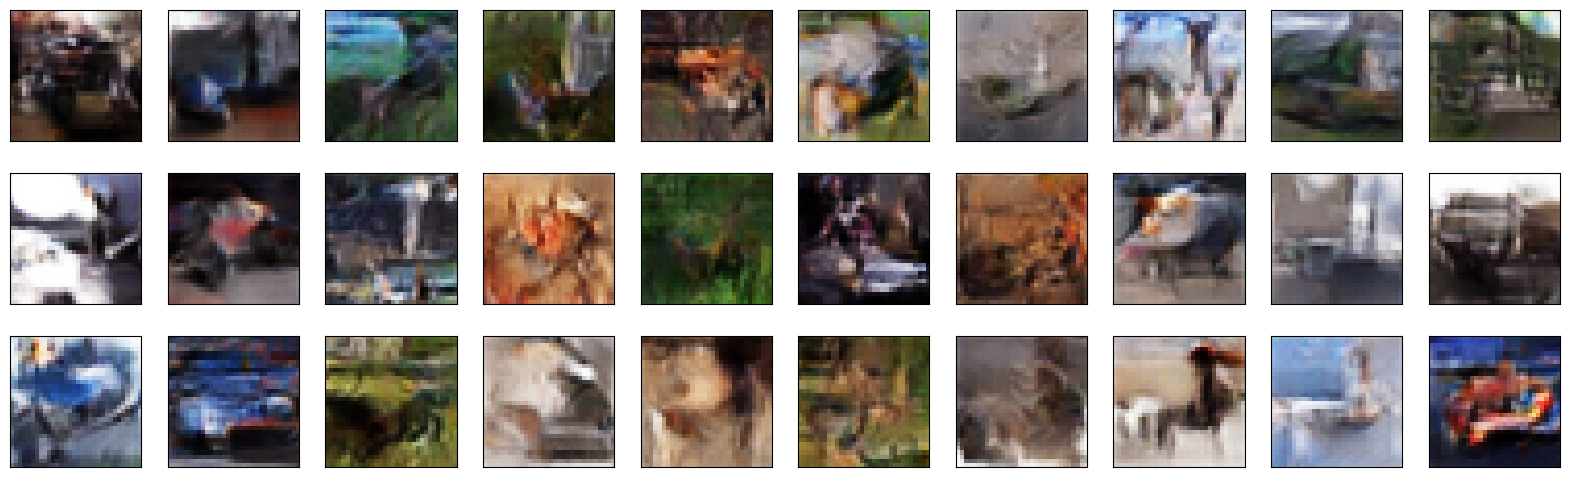

* epoch: 42, d_loss: 491.652040, g_loss: 3780.434016
1/1 [==============================] - 0s 15ms/step


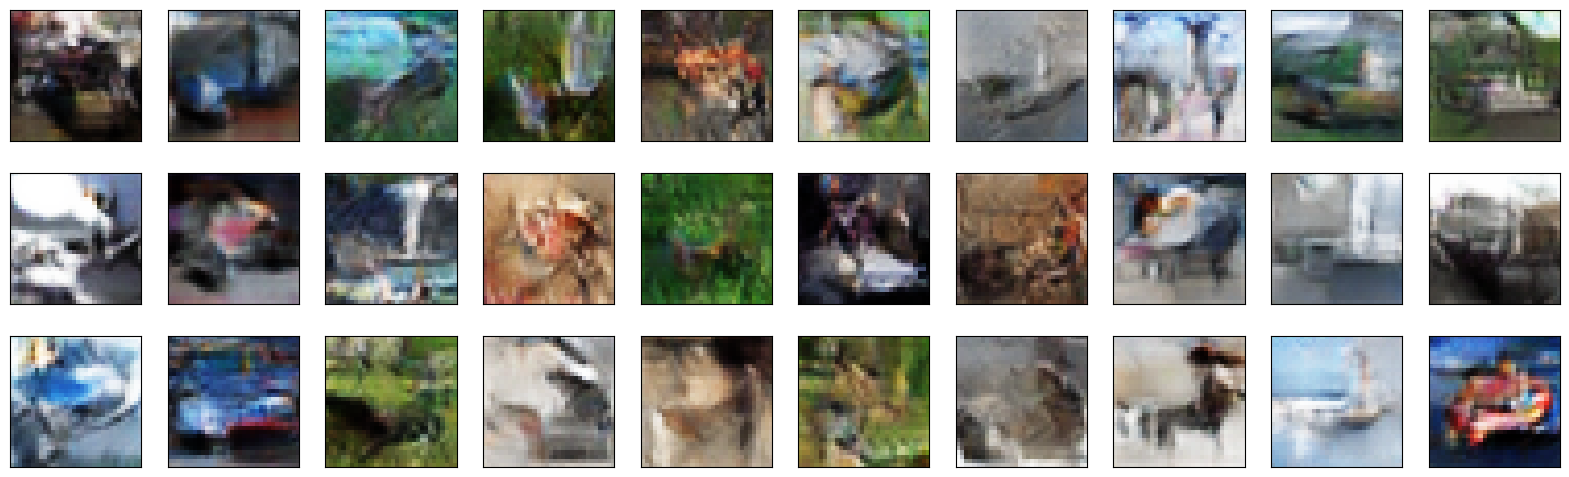

* epoch: 43, d_loss: 470.930535, g_loss: 4126.568302
1/1 [==============================] - 0s 16ms/step


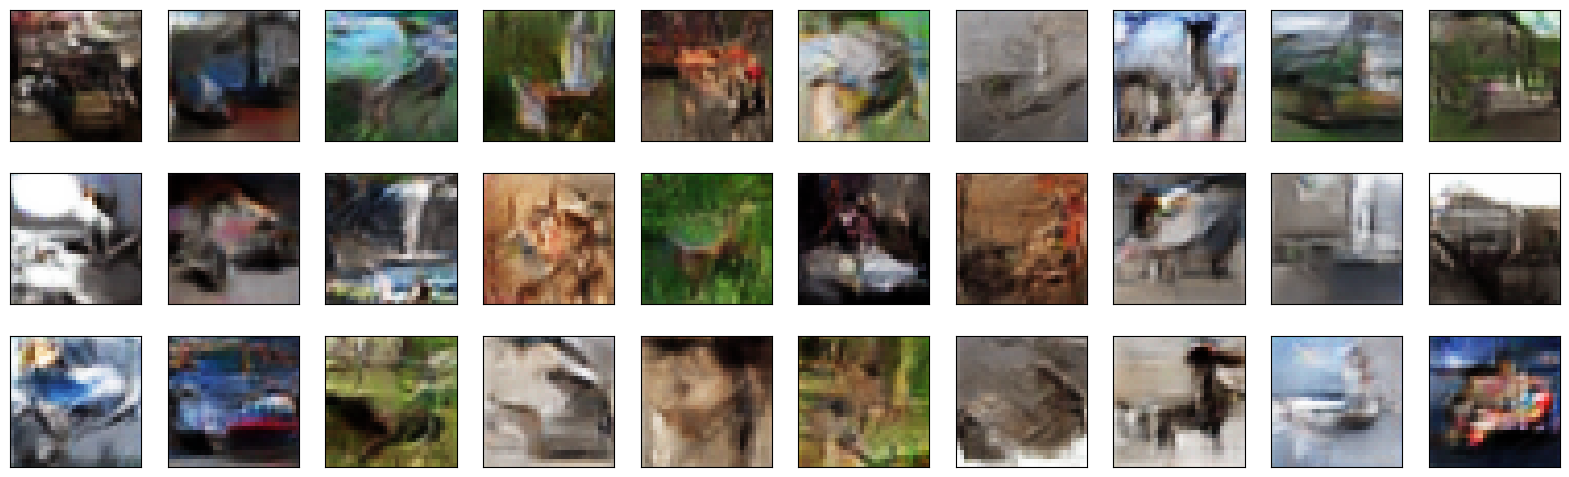

* epoch: 44, d_loss: 469.805308, g_loss: 4006.896255
1/1 [==============================] - 0s 15ms/step


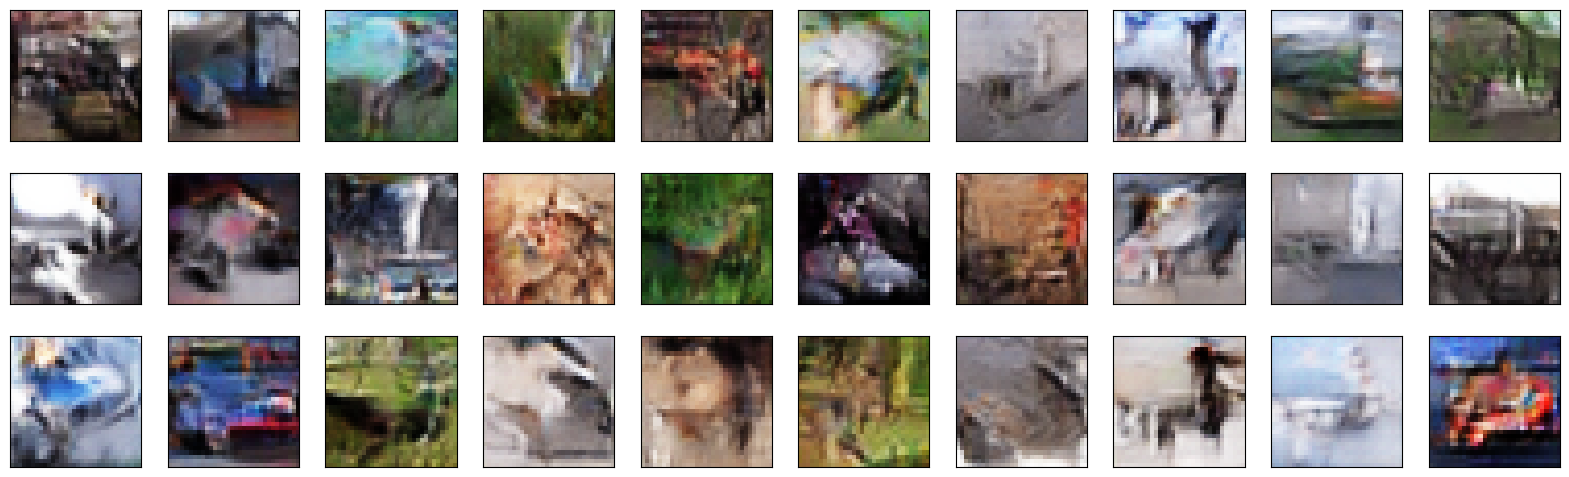

* epoch: 45, d_loss: 493.059252, g_loss: 3841.160147
1/1 [==============================] - 0s 15ms/step


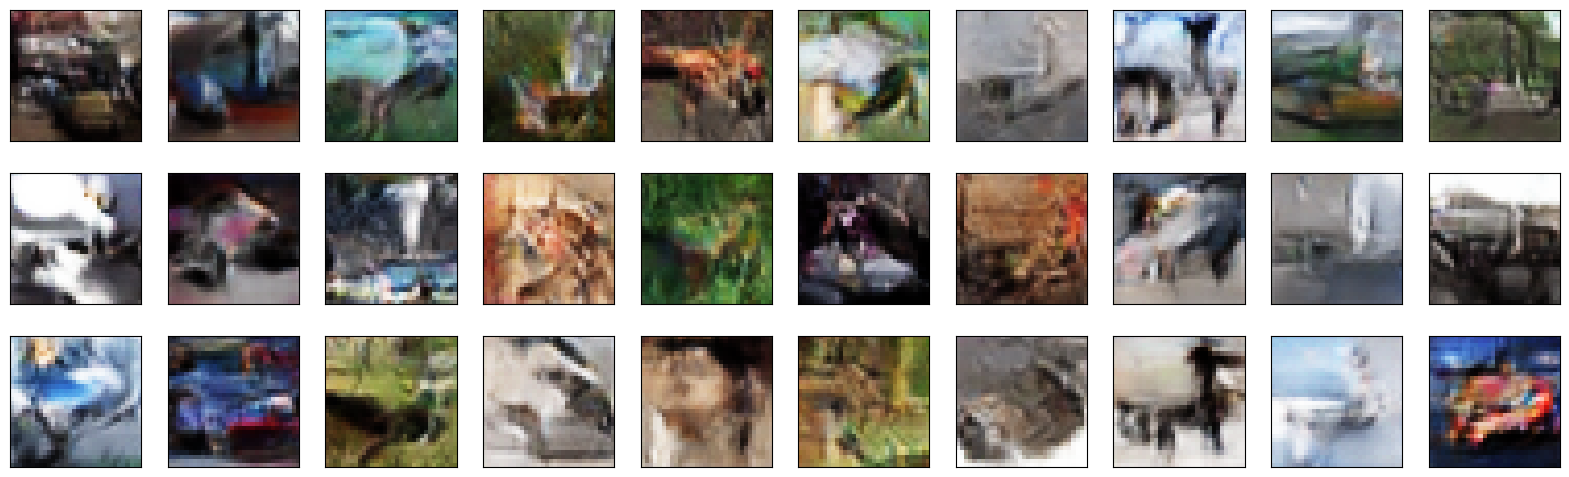

* epoch: 46, d_loss: 462.918597, g_loss: 4118.559087
1/1 [==============================] - 0s 15ms/step


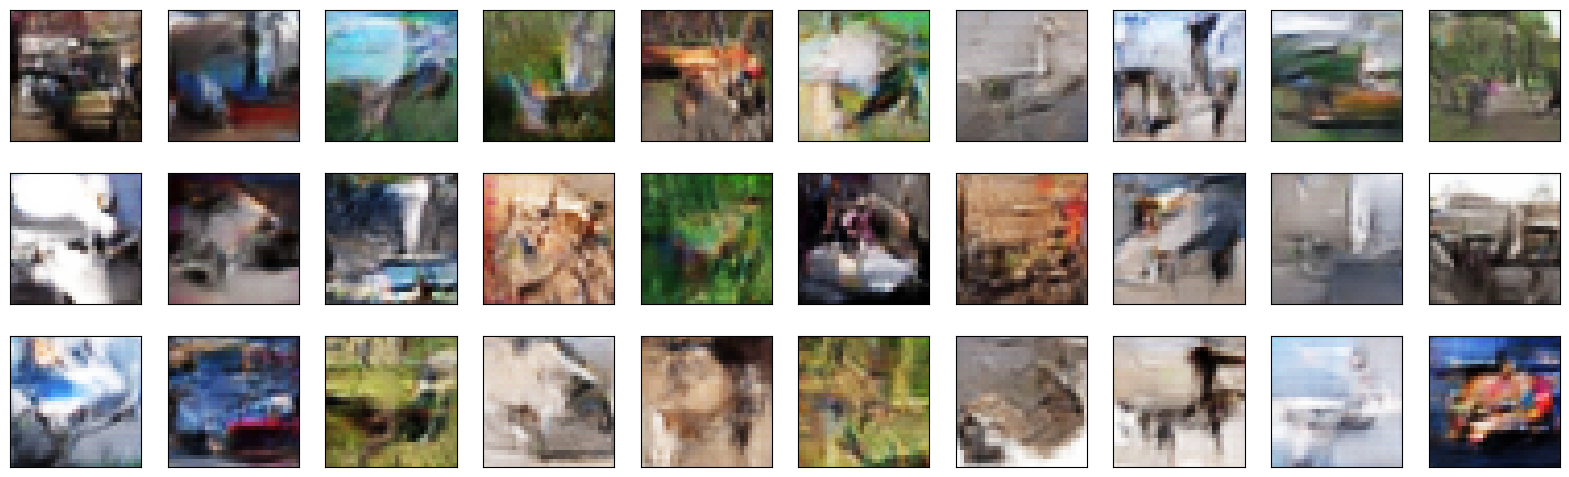

* epoch: 47, d_loss: 486.393536, g_loss: 3849.258059
1/1 [==============================] - 0s 15ms/step


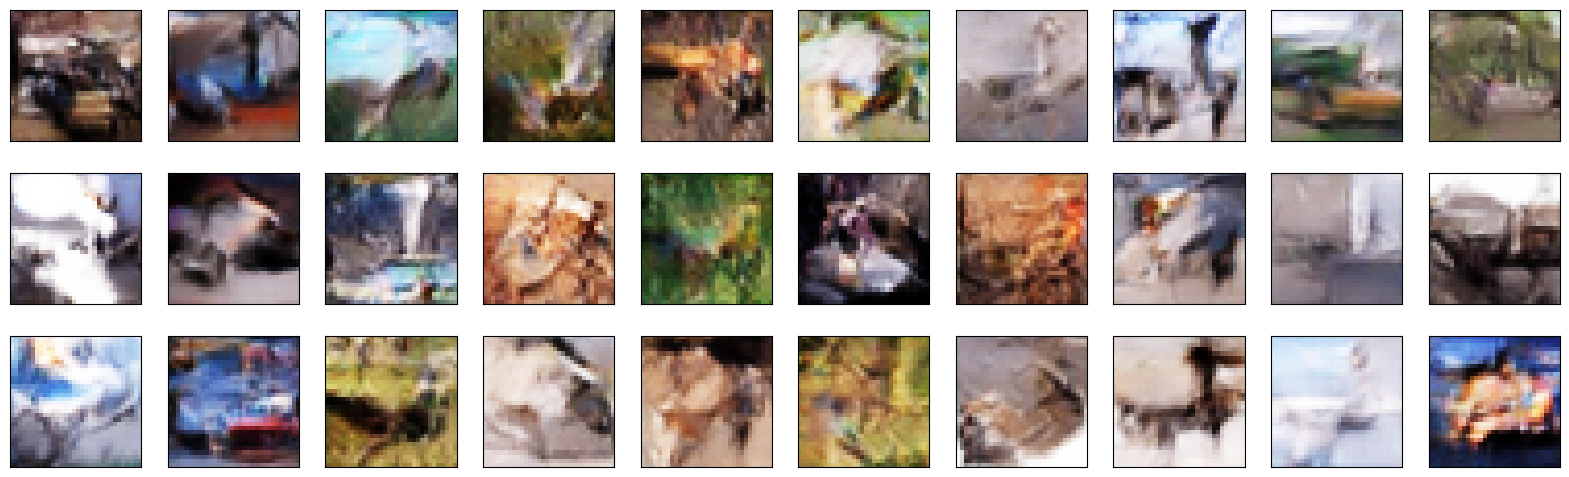

* epoch: 48, d_loss: 470.503922, g_loss: 4038.248942
1/1 [==============================] - 0s 15ms/step


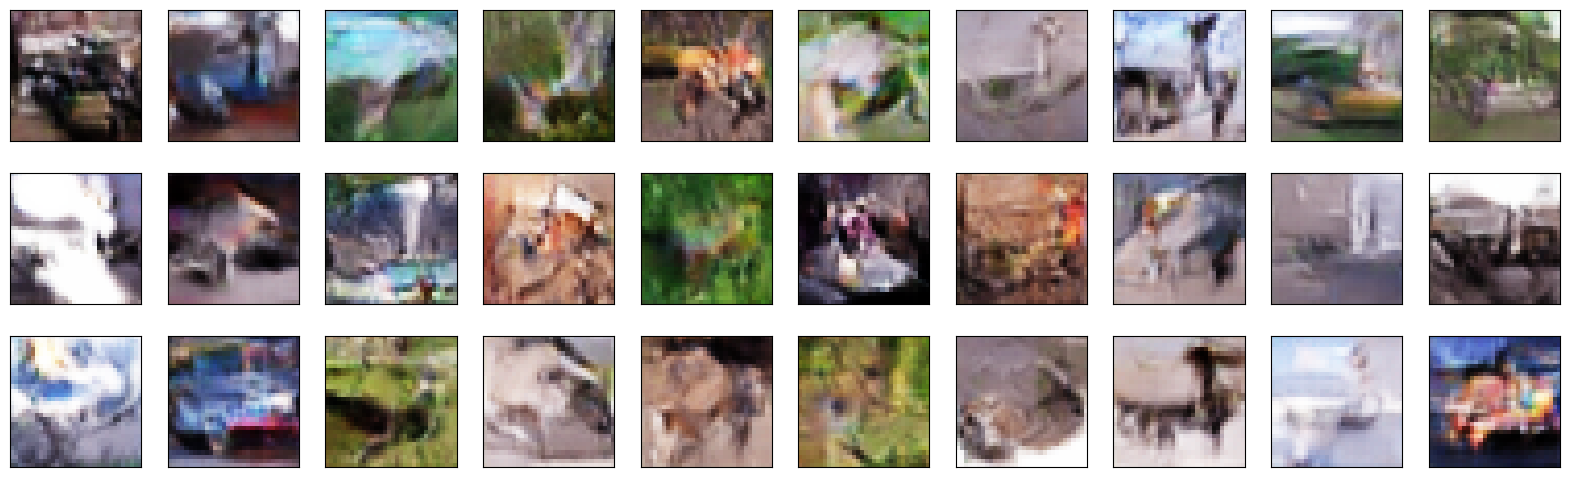

* epoch: 49, d_loss: 449.924517, g_loss: 4157.173820
1/1 [==============================] - 0s 15ms/step


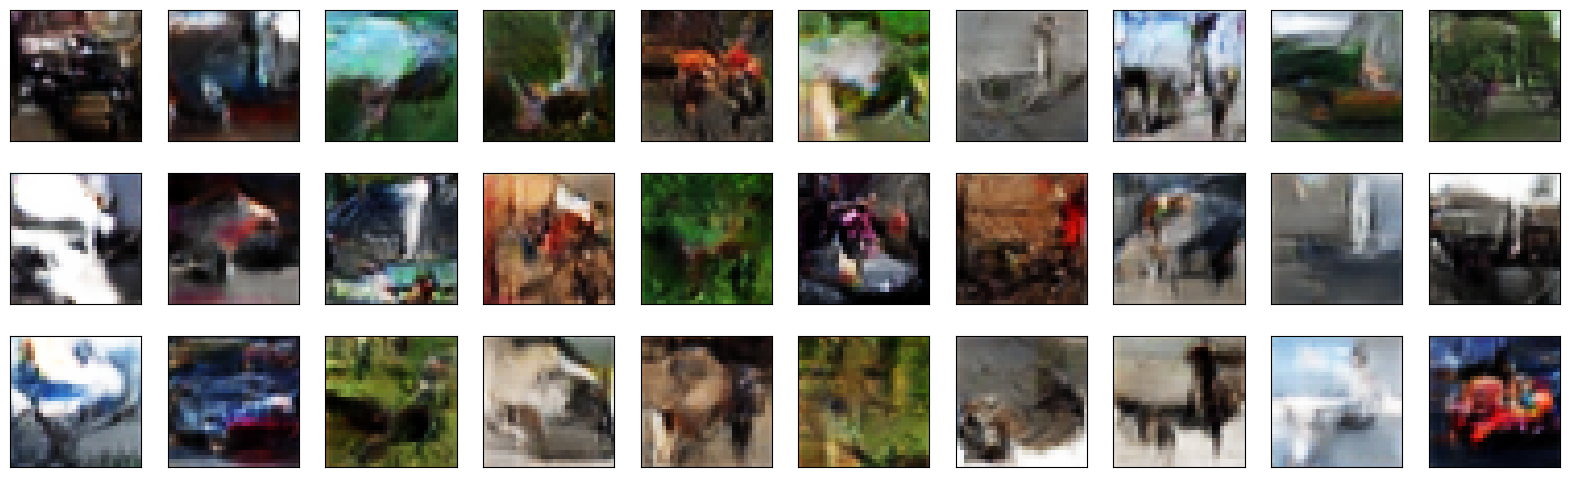

* epoch: 50, d_loss: 458.782445, g_loss: 4281.325691
1/1 [==============================] - 0s 15ms/step


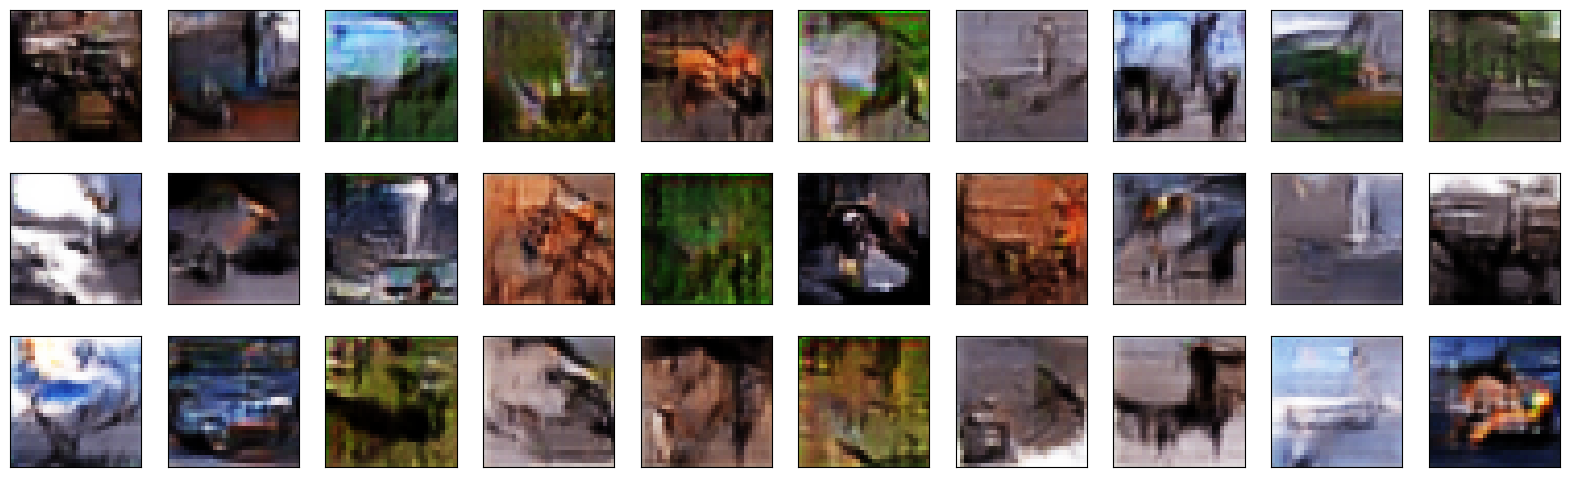

In [11]:
model = GAN(gene, disc, IMG_SHAPE, NOISE_DIM,LABEL_DIM)
model.Compile()
model.gan.summary()
model.fit(x_train,y_data=y_train,  epochs= 50, standard=True)